 # First model: CLIP

In [ ]:
# !pip install --upgrade sympy==1.12


In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [ ]:
# import shutil
# import os

# for item in os.listdir("/content"):
#     if item not in ["sample_data"]:
#         path = os.path.join("/content", item)
#         if os.path.isdir(path):
#             shutil.rmtree(path)
#         else:
#             os.remove(path)


In [ ]:
# !rm -rf /root/.cache/huggingface/hub
# !rm -rf /root/.cache/torch
# !rm -rf /root/.cache/kagglehub

In [ ]:
# !ls -la /content


total 16
drwxr-xr-x 1 root root 4096 Apr 11 13:37 .
drwxr-xr-x 1 root root 4096 Apr 16 18:13 ..
drwxr-xr-x 4 root root 4096 Apr 11 13:37 .config
drwxr-xr-x 1 root root 4096 Apr 11 13:37 sample_data


In [ ]:
# !rm -rf /content/llama.cpp


In [ ]:
!rm -rf LLaVA


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [ ]:
# from google.colab import files

In [ ]:
import shutil
shutil.rmtree("/content/DFDC", ignore_errors=True)

In [ ]:
pip install kaggle

In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)

shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)

!pip install kaggle


In [ ]:
!KAGGLE_CONFIG_DIR="/root/.kaggle" kaggle competitions download -c deepfake-detection-challenge

100% 4.12G/4.13G [00:47<00:00, 33.3MB/s]
100% 4.13G/4.13G [00:47<00:00, 94.0MB/s]


In [ ]:
import os

ZIP_PATH = "/content/deepfake-detection-challenge.zip"
DATASET_PATH = "/content/DFDC"

!unzip -q {ZIP_PATH} -d {DATASET_PATH}

print(os.listdir(DATASET_PATH))


['sample_submission.csv', 'test_videos', 'train_sample_videos']


In [ ]:
import json

METADATA_PATH = os.path.join(DATASET_PATH, "train_sample_videos", "metadata.json")

with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

# Only real ones
real_videos = [video for video, info in metadata.items() if info["label"] == "REAL"]

print(len(real_videos), "real videos are found")


77 real videos are found


Extracting frames from real video

In [ ]:
import cv2

# Frames
REAL_FRAMES_PATH = os.path.join(DATASET_PATH, "real_frames")
os.makedirs(REAL_FRAMES_PATH, exist_ok=True)

# Frames extration function
def extract_frames(video_list, max_frames=5):
    for video_file in video_list:
        video_path = os.path.join(DATASET_PATH, "train_sample_videos", video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            # Save the frame
            frame_filename = f"{video_file}_frame{frame_count}.jpg"
            frame_path = os.path.join(REAL_FRAMES_PATH, frame_filename)
            cv2.imwrite(frame_path, frame)
            frame_count += 1

        cap.release()

# Extract frames
extract_frames(real_videos)

In [ ]:
num_real_frames = len(os.listdir(REAL_FRAMES_PATH))
print(num_real_frames)

385


Visualization of sample frames

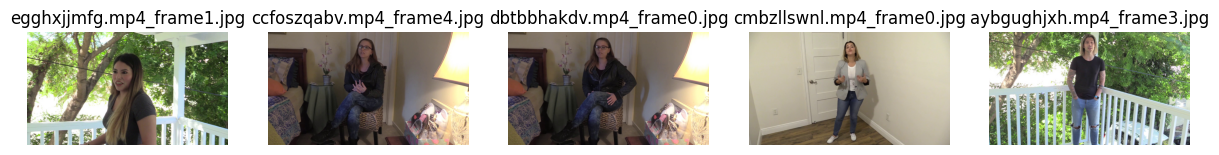

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_images(image_folder, num_images=5):
    image_files = os.listdir(image_folder)
    sample_files = random.sample(image_files, min(num_images, len(image_files)))

    fig, axes = plt.subplots(1, len(sample_files), figsize=(15, 5))
    for ax, img_file in zip(axes, sample_files):
        img_path = os.path.join(image_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(img_file)
        ax.axis("off")

plot_images(REAL_FRAMES_PATH)
plt.show()


In [ ]:
FAKE_FRAMES_PATH = "/content/DFDC/fake_frames"
os.makedirs(FAKE_FRAMES_PATH, exist_ok=True)


Теперь реализация CLIP для DFDC:

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
from tqdm import tqdm
import pickle

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# real frames DFDC
REAL_FRAMES_PATH = "/content/DFDC/real_frames"
frame_files = sorted(os.listdir(REAL_FRAMES_PATH))[:70]
embeddings = []

for file in tqdm(frame_files, desc="Extracting embeddings (70 frames)"):
    path = os.path.join(REAL_FRAMES_PATH, file)
    image = Image.open(path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding.cpu().squeeze().numpy()

    embeddings.append(embedding)


with open("clip_embeddings_dfdc.pkl", "wb") as f:
    pickle.dump(embeddings, f)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Extracting embeddings (70 frames): 100%|██████████| 70/70 [00:23<00:00,  3.04it/s]


In [ ]:
from google.colab import files
import pickle


with open("clip_embeddings_dfdc.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data))
print(data[:1])

<class 'list'>
70
[array([-1.86070651e-01,  2.17079252e-01,  4.11402881e-02,  3.57416838e-01,
        1.85870588e-01, -1.20242149e-01,  3.95550579e-02,  3.48936379e-01,
        6.70640588e-01,  1.16659045e-01,  5.17992139e-01, -2.54167080e-01,
       -4.48670506e-01,  4.30636019e-01, -1.69352204e-01,  4.99019772e-01,
       -7.54371405e-01,  2.73530841e-01,  1.10531598e-01,  1.45355403e-01,
        6.60751104e-01,  2.51732022e-03,  1.17866278e-01, -3.12900960e-01,
       -1.85022831e-01, -6.41431287e-02,  4.57738936e-01, -5.58975339e-02,
        1.76083818e-01, -2.59386003e-01,  2.07863897e-02, -2.59374753e-02,
        1.40133202e-01, -2.81425059e-01,  5.78083634e-01,  2.27318555e-01,
       -1.47772223e-01,  9.35999155e-02, -1.24488942e-01, -5.01241446e-01,
       -1.12395704e-01,  3.67858410e-02,  6.29017726e-02, -4.73263681e-01,
        1.31873339e-01,  5.93376756e-01,  1.91829979e-01, -3.94332767e-01,
       -6.32780604e-03,  1.61285967e-01, -1.54117584e-01, -2.31225759e-01,
      

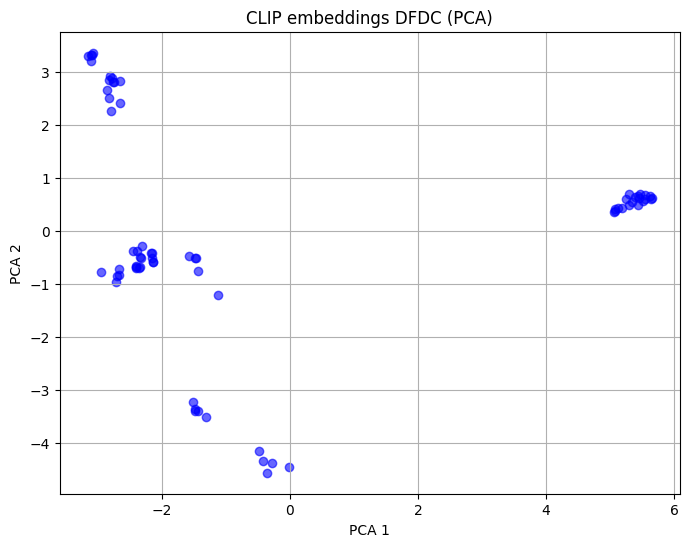

In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

with open("clip_embeddings_dfdc.pkl", "rb") as f:
    embeddings = pickle.load(f)

embeddings = np.array(embeddings)

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c='blue', alpha=0.6)
plt.title("CLIP embeddings DFDC (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


Loading StyleGAN dataset (7k fake images only):



In [ ]:
!pip install kagglehub

In [ ]:
#  import os
#  from PIL import Image
#  import matplotlib.pyplot as plt
#  import kagglehub

#  path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")
#  fake_path = os.path.join(path, 'Final Dataset', 'Fake')
#  print(fake_path)
#  print(os.listdir(fake_path)[:5])

/kaggle/input/deepfake-face-images/Final Dataset/Fake
['fake_639_aug_1.jpg', '1JD6S89G4D.jpg', '1KCN62R2WA.jpg', '1FKIB1PX33.jpg', '0AMO1SB5CD.jpg']


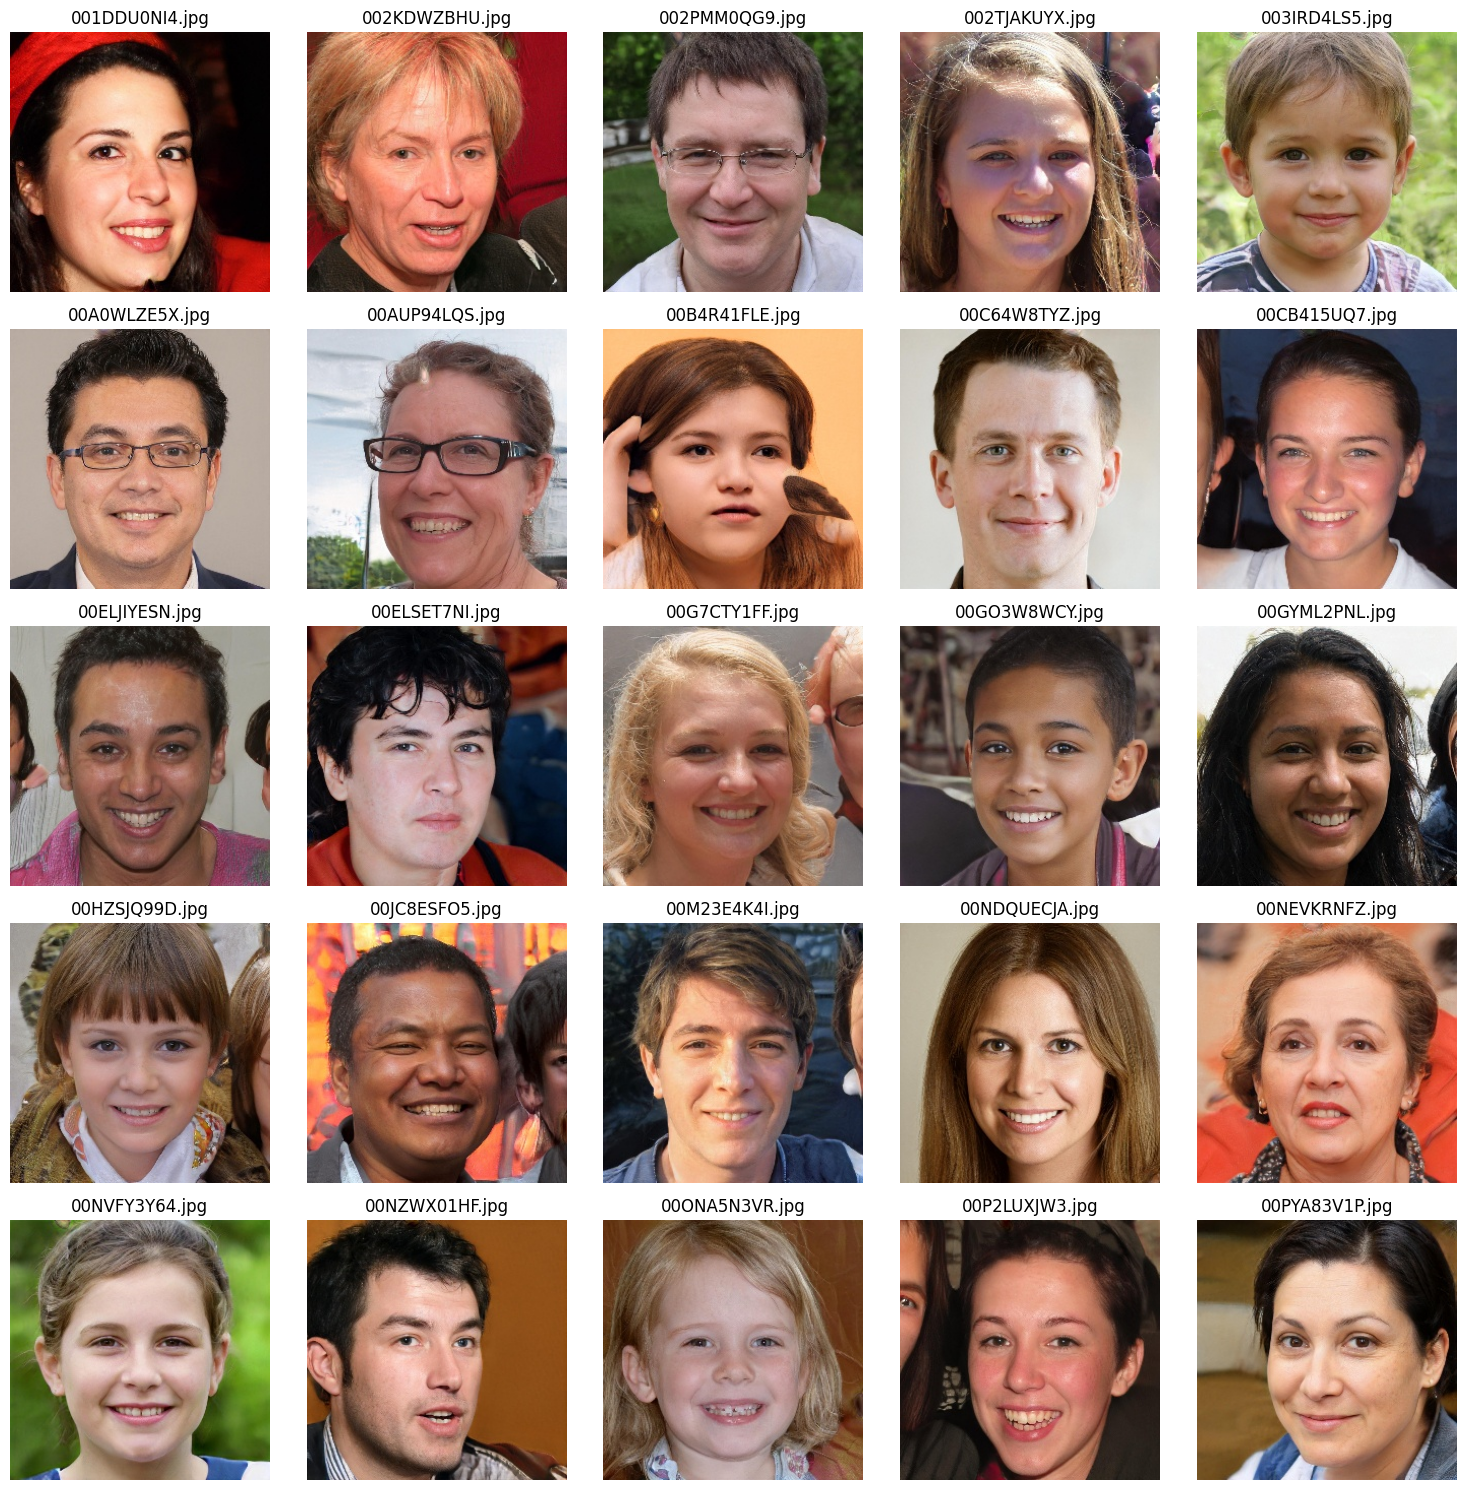

In [ ]:
# files = sorted(os.listdir(fake_path))[:25]

# plt.figure(figsize=(15, 15))

# for idx, file_name in enumerate(files):
#     img_path = os.path.join(fake_path, file_name)
#     img = Image.open(img_path)

#     plt.subplot(5, 5, idx + 1)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(file_name)

# plt.tight_layout()
# plt.show()


In [ ]:
# print(fake_path)
# print(os.listdir(fake_path)[:5])


/kaggle/input/deepfake-face-images/Final Dataset/Fake
['fake_639_aug_1.jpg', '1JD6S89G4D.jpg', '1KCN62R2WA.jpg', '1FKIB1PX33.jpg', '0AMO1SB5CD.jpg']


In [ ]:
import kagglehub
path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")
fake_path = os.path.join(path, 'Final Dataset', 'Fake')

In [ ]:
print(os.listdir(fake_path)[:5])

['fake_639_aug_1.jpg', '1JD6S89G4D.jpg', '1KCN62R2WA.jpg', '1FKIB1PX33.jpg', '0AMO1SB5CD.jpg']


Extracting embeddings for this dataset (via CLIP):

In [ ]:
import torch
from tqdm import tqdm
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pickle

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# First 70 images
files = sorted([
    f for f in os.listdir(fake_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])[:70]

embeddings = []

for file in tqdm(files, desc="CLIP StyleGAN Embeddings"):
    image = Image.open(os.path.join(fake_path, file)).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding.cpu().squeeze().numpy()

    embeddings.append(embedding)

print(len(embeddings))

with open('clip_embeddings_stylegan.pkl', 'wb') as f:
    pickle.dump(embeddings, f)


CLIP StyleGAN Embeddings: 100%|██████████| 70/70 [00:16<00:00,  4.13it/s]

70


In [ ]:
import pickle

file_path = "/content/clip_embeddings_stylegan.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data))
print(data[:1])


<class 'list'>
70
[array([ 2.00043380e-01, -2.13722810e-01, -3.57580364e-01,  3.40098143e-02,
        5.06557465e-01, -1.67511821e-01,  1.68790892e-01, -2.08897769e-01,
       -1.39398366e-01, -5.84100187e-02, -1.33142114e-01,  6.08777627e-02,
        2.00099468e-01,  2.31409416e-01,  3.05923343e-01, -4.44206089e-01,
        7.57194042e-01,  5.95138609e-01, -4.06526774e-01,  3.88147146e-01,
        2.25724801e-01, -1.71357691e-01, -2.79865593e-01, -3.79725397e-02,
       -2.05134451e-01,  3.68572652e-01, -8.60264301e-02,  3.95943046e-01,
        4.17013973e-01, -3.03221941e-02,  2.81585306e-01,  9.74242017e-02,
       -8.78893211e-02,  2.99123451e-02,  2.34805688e-01, -1.92044452e-02,
        3.73697668e-01,  4.32657629e-01,  2.45536730e-01,  5.63356996e-01,
        1.89829201e-01, -1.87707976e-01, -5.18265843e-01, -2.61819601e-01,
       -3.01918179e-01,  1.13063872e+00,  2.75933713e-01,  3.72234225e-01,
       -1.41916692e-01, -1.26611069e-01,  7.24083781e-02,  1.11323595e-01,
      

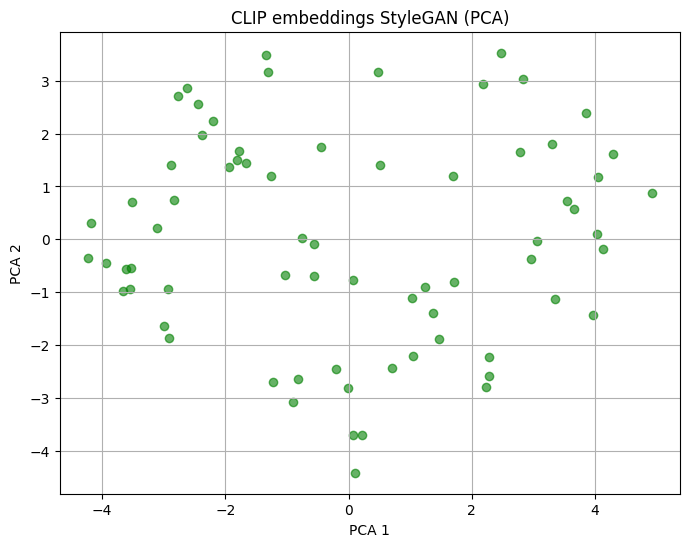

In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


with open("clip_embeddings_stylegan.pkl", "rb") as f:
    embeddings = pickle.load(f)


embeddings = np.array(embeddings)


pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)


plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c='green', alpha=0.6)
plt.title("CLIP embeddings StyleGAN (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


Loading the ArtiFact dataset and extracting embeddings (subset big_gan):

In [ ]:
!unzip -q /content/big_gan.zip -d /content/big_gan


In [ ]:
import torch
from tqdm import tqdm
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pickle


artifact_path = "/content/big_gan/big/biggan-data"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


image_paths = []
for root, dirs, files in os.walk(artifact_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

# First 70 images
image_paths = image_paths[:70]


embeddings = []
for path in tqdm(image_paths):
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding.cpu().squeeze().numpy()

    embeddings.append(embedding)

with open("clip_embeddings_biggan.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print(len(embeddings))



100%|██████████| 70/70 [00:16<00:00,  4.12it/s]

70


In [ ]:
from google.colab import files
import pickle


with open("clip_embeddings_biggan.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data))
print(data[:1])

<class 'list'>
70
[array([-6.79435655e-02,  1.13403827e-01, -2.11639464e-01, -4.40683097e-01,
        2.58171558e-03, -3.20051819e-01,  1.78161934e-01,  5.13763249e-01,
        3.23396742e-01,  3.65263849e-01, -1.62725449e-02,  3.99583019e-03,
        6.93277717e-02,  2.16442049e-01, -1.82982355e-01,  2.43237674e-01,
        1.46937728e-01,  4.07489330e-01,  1.58099115e-01,  2.01809049e-01,
       -5.16229391e-01, -1.99219137e-01,  1.32678822e-01, -7.50237182e-02,
       -4.38600957e-01, -1.22613713e-01, -4.05701160e-01,  4.05529201e-01,
       -1.73219085e-01,  1.36453182e-01,  3.24562073e-01,  2.36510664e-01,
        1.62026405e-01, -3.03487420e-01, -4.28103983e-01, -3.38250369e-01,
       -2.32442707e-01,  8.72062445e-02, -2.74611354e-01, -3.48043114e-01,
        2.93348014e-01, -2.86552787e-01, -2.97984779e-02,  5.32574877e-02,
        1.11725770e-01, -1.37307501e+00,  3.81511241e-01,  4.25069451e-01,
        5.68694651e-01, -3.22232366e-01, -7.12125152e-02, -6.93809092e-02,
      

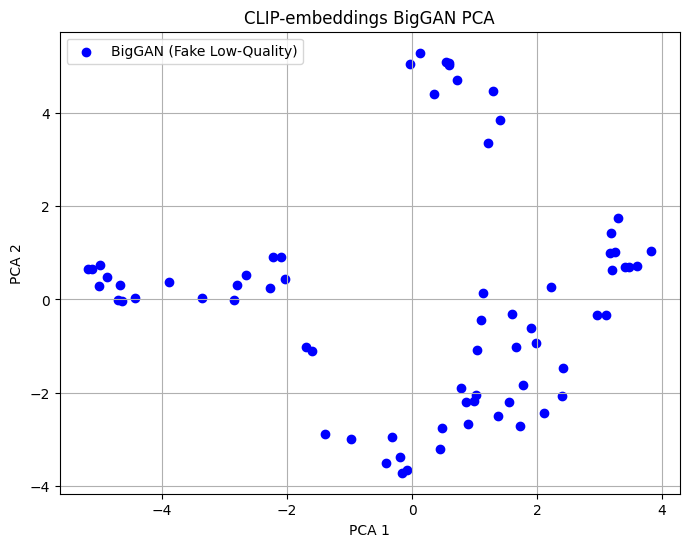

In [ ]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

with open("clip_embeddings_biggan.pkl", "rb") as f:
    embeddings = pickle.load(f)

X = np.array(embeddings)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c="blue", label="BigGAN (Fake Low-Quality)")
plt.title("CLIP-embeddings BigGAN PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


# Second model: BLIP2

BLIP-2 for StyleGAN (20 images):

In [ ]:
pip install kaggle

In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)

shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)

!pip install kaggle


In [ ]:
!pip install -q transformers timm accelerate kagglehub

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")
fake_path = os.path.join(path, 'Final Dataset', 'Fake')

image_files = sorted([f for f in os.listdir(fake_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
image_paths = [os.path.join(fake_path, f) for f in image_files[:70]]  # 70 images

In [ ]:
import torch
from transformers import Blip2Processor, Blip2Model
from PIL import Image
from tqdm import tqdm
import pickle

device = torch.device("cpu")

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
model.eval()

embeddings = {}

for image_path in tqdm(image_paths):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        image_embeds = model.vision_model(**inputs).last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    image_name = os.path.basename(image_path)
    embeddings[image_name] = image_embeds

with open("blip2_embeddings_stylegan.pkl", "wb") as f:
    pickle.dump(embeddings, f)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 70/70 [12:29<00:00, 10.70s/it]


In [ ]:
import pickle

file_path = "blip2_embeddings_stylegan.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data))

for i, (k, v) in enumerate(data.items()):
    print(i + 1, ". key:", k, "shape:", v.shape)
    if i >= 2:
        break


<class 'dict'>
70
1 . key: 001DDU0NI4.jpg shape: (1408,)
2 . key: 002KDWZBHU.jpg shape: (1408,)
3 . key: 002PMM0QG9.jpg shape: (1408,)


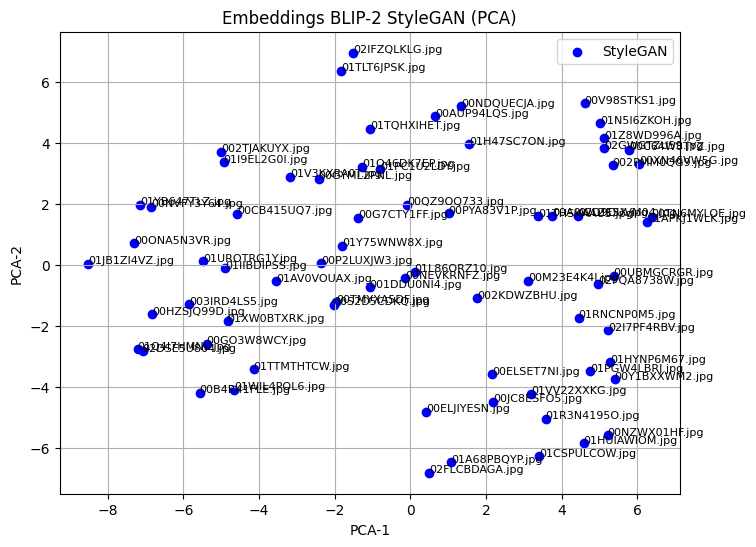

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


with open("blip2_embeddings_stylegan.pkl", "rb") as f:
    embeddings_dict = pickle.load(f)

image_names = list(embeddings_dict.keys())
embeddings = np.array(list(embeddings_dict.values()))

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c='blue', label="StyleGAN")
for i, name in enumerate(image_names):
    plt.text(reduced[i, 0], reduced[i, 1], name, fontsize=8)
plt.title("Embeddings BLIP-2 StyleGAN (PCA)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend()
plt.grid(True)
plt.show()


BLIP-2 implementation for DFDC:

In [ ]:
!pip install -q transformers accelerate timm bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 123.0 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
!KAGGLE_CONFIG_DIR="/root/.kaggle" kaggle competitions download -c deepfake-detection-challenge

In [ ]:
ZIP_PATH = "/content/deepfake-detection-challenge.zip"
DATASET_PATH = "/content/DFDC"

In [ ]:
!unzip -q {ZIP_PATH} -d {DATASET_PATH}

In [ ]:
print(os.listdir(DATASET_PATH))

['train_sample_videos', 'sample_submission.csv', 'test_videos', 'real_frames']


In [ ]:
import json

METADATA_PATH = os.path.join(DATASET_PATH, "train_sample_videos", "metadata.json")

with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

# Only real ones
real_videos = [video for video, info in metadata.items() if info["label"] == "REAL"]

print(len(real_videos), "real videos are found")

77 real videos are found


In [ ]:
import cv2

# Frames
REAL_FRAMES_PATH = os.path.join(DATASET_PATH, "real_frames")
os.makedirs(REAL_FRAMES_PATH, exist_ok=True)

# Frames extration function
def extract_frames(video_list, max_frames=5):
    for video_file in video_list:
        video_path = os.path.join(DATASET_PATH, "train_sample_videos", video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while cap.isOpened() and frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            # Save the frame
            frame_filename = f"{video_file}_frame{frame_count}.jpg"
            frame_path = os.path.join(REAL_FRAMES_PATH, frame_filename)
            cv2.imwrite(frame_path, frame)
            frame_count += 1

        cap.release()

# Extract frames
extract_frames(real_videos)
num_real_frames = len(os.listdir(REAL_FRAMES_PATH))
print(num_real_frames)


385


In [ ]:
import torch
from transformers import Blip2Processor, Blip2Model
from PIL import Image
import os
import pickle
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

REAL_FRAMES_PATH = "/content/DFDC/real_frames"
image_files = sorted([
    f for f in os.listdir(REAL_FRAMES_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])
image_paths = [os.path.join(REAL_FRAMES_PATH, f) for f in image_files[:70]]  # first 70 images

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
model.eval()

embeddings = {}
for img_path in tqdm(image_paths):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        vision_output = model.vision_model(**inputs)
        embedding = vision_output.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    image_name = os.path.basename(img_path)
    embeddings[image_name] = embedding

with open("blip2_embeddings_dfdc.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print(len(embeddings))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 70/70 [12:34<00:00, 10.77s/it]

70


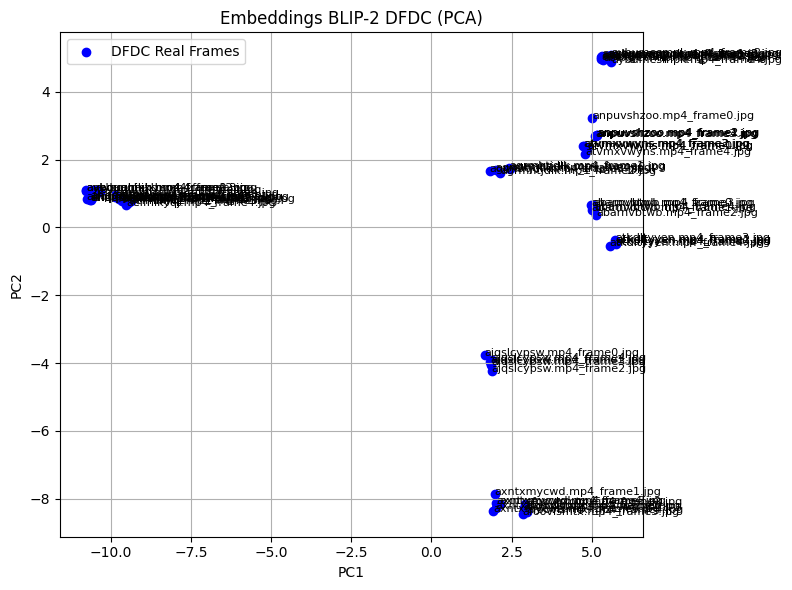

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with open("blip2_embeddings_dfdc.pkl", "rb") as f:
    embeddings = pickle.load(f)

image_names = list(embeddings.keys())
embedding_matrix = np.array([embeddings[name] for name in image_names])

pca = PCA(n_components=2)
reduced = pca.fit_transform(embedding_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c='blue', label='DFDC Real Frames')
for i, name in enumerate(image_names):
    plt.text(reduced[i, 0], reduced[i, 1], name, fontsize=8)
plt.title("Embeddings BLIP-2 DFDC (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with open("blip2_embeddings_dfdc.pkl", "rb") as f:
    embeddings = pickle.load(f)

print("blip2_embeddings_dfdc.pkl:\n")
for k, v in embeddings.items():
    print(k, ":", v.shape)

blip2_embeddings_dfdc.pkl:

abarnvbtwb.mp4_frame0.jpg : (1408,)
abarnvbtwb.mp4_frame1.jpg : (1408,)
abarnvbtwb.mp4_frame2.jpg : (1408,)
abarnvbtwb.mp4_frame3.jpg : (1408,)
abarnvbtwb.mp4_frame4.jpg : (1408,)
aelfnikyqj.mp4_frame0.jpg : (1408,)
aelfnikyqj.mp4_frame1.jpg : (1408,)
aelfnikyqj.mp4_frame2.jpg : (1408,)
aelfnikyqj.mp4_frame3.jpg : (1408,)
aelfnikyqj.mp4_frame4.jpg : (1408,)
afoovlsmtx.mp4_frame0.jpg : (1408,)
afoovlsmtx.mp4_frame1.jpg : (1408,)
afoovlsmtx.mp4_frame2.jpg : (1408,)
afoovlsmtx.mp4_frame3.jpg : (1408,)
afoovlsmtx.mp4_frame4.jpg : (1408,)
agrmhtjdlk.mp4_frame0.jpg : (1408,)
agrmhtjdlk.mp4_frame1.jpg : (1408,)
agrmhtjdlk.mp4_frame2.jpg : (1408,)
agrmhtjdlk.mp4_frame3.jpg : (1408,)
agrmhtjdlk.mp4_frame4.jpg : (1408,)
ahqqqilsxt.mp4_frame0.jpg : (1408,)
ahqqqilsxt.mp4_frame1.jpg : (1408,)
ahqqqilsxt.mp4_frame2.jpg : (1408,)
ahqqqilsxt.mp4_frame3.jpg : (1408,)
ahqqqilsxt.mp4_frame4.jpg : (1408,)
ajqslcypsw.mp4_frame0.jpg : (1408,)
ajqslcypsw.mp4_frame1.jpg : (1408,)


t-SNE:

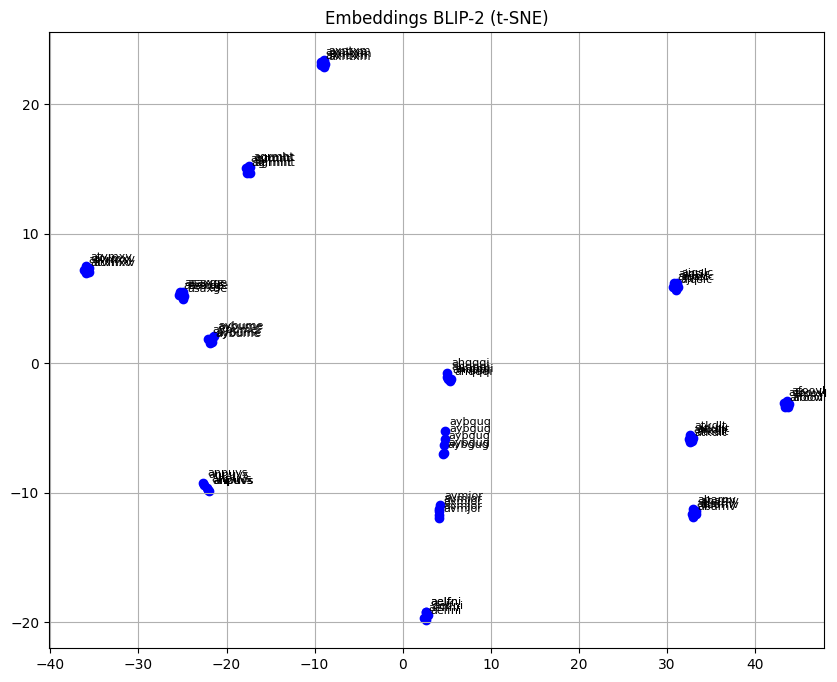

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

with open("blip2_embeddings_dfdc.pkl", "rb") as f:
    embeddings = pickle.load(f)

image_names = list(embeddings.keys())
vectors = np.array(list(embeddings.values()))

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 8))
for i, name in enumerate(image_names):
    x, y = reduced[i]
    plt.scatter(x, y, color='blue')
    plt.text(x + 0.5, y + 0.5, name[:6], fontsize=8)
plt.title("Embeddings BLIP-2 (t-SNE)")
plt.grid(True)
plt.show()


In [ ]:
я# import pickle

# with open("blip2_embeddings_dfdc.pkl", "rb") as f:
#     data = pickle.load(f)


# print(type(data))
# print(len(data))

# print(list(data.keys())[:5])

# first_key = list(data.keys())[0]
# first_embedding = data[first_key]
# print("File:", first_key)
# print("Embedding size:", first_embedding.shape)
# print("Embeddnig (start):", first_embedding[:10])


<class 'dict'>
20
['abarnvbtwb.mp4_frame0.jpg', 'abarnvbtwb.mp4_frame1.jpg', 'abarnvbtwb.mp4_frame2.jpg', 'abarnvbtwb.mp4_frame3.jpg', 'abarnvbtwb.mp4_frame4.jpg']
File: abarnvbtwb.mp4_frame0.jpg
Embedding size: (1408,)
Embeddnig (start): [ 0.14509162  0.14448614 -0.27447465  0.7355491  -0.29373848 -0.6897316
  0.10464167  0.29082382  0.10166398  0.10390758]


BLIP-2 for BigGAN (from ArtiFact):

In [ ]:
!unzip -q /content/big_gan.zip -d /content/big_gan

In [ ]:
import torch
from tqdm import tqdm
import os
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pickle


artifact_path = "/content/big_gan/big/biggan-data"

Visualization of the BiGGAN:

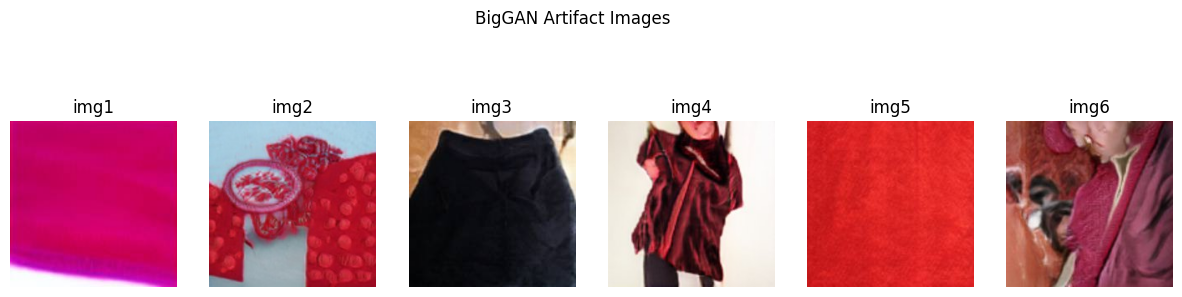

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

artifact_path = "/content/big_gan/big/biggan-data"

def show_examples(dataset_path, title, num_images=6):
    image_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in sorted(files):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    image_paths = image_paths[:num_images]

    plt.figure(figsize=(15, 4))
    for i, path in enumerate(image_paths):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("img" + str(i + 1))
    plt.suptitle(title)
    plt.show()

show_examples(artifact_path, "BigGAN Artifact Images")

In [ ]:
!pip install -q transformers timm accelerate bitsandbytes

In [ ]:
import os
from PIL import Image
import torch
from transformers import Blip2Processor, Blip2Model
from tqdm import tqdm
import pickle

device = torch.device("cpu")

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
model.eval()

artifact_path = "/content/big_gan/big/biggan-data"
all_image_paths = []

for root, _, files in os.walk(artifact_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            all_image_paths.append(os.path.join(root, file))

# First 70 images
all_image_paths = all_image_paths[:70]
print(len(all_image_paths))

embeddings = {}
with torch.no_grad():
    for path in tqdm(all_image_paths, desc="BLIP-2 BigGAN Embeddings"):
        filename = os.path.basename(path)
        tqdm.write("Processing " + filename)

        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        vision_outputs = model.vision_model(**inputs)
        image_embed = vision_outputs.last_hidden_state[:, 0, :].squeeze().cpu()

        embeddings[filename] = image_embed

with open("blip2_embeddings_biggan.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print(len(embeddings))




Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

70


BLIP-2 BigGAN Embeddings:   0%|          | 0/70 [00:00<?, ?it/s]

Processing img008730.jpg


BLIP-2 BigGAN Embeddings:   1%|▏         | 1/70 [00:11<13:05, 11.39s/it]

Processing img008731.jpg


BLIP-2 BigGAN Embeddings:   3%|▎         | 2/70 [00:22<12:33, 11.08s/it]

Processing img008732.jpg


BLIP-2 BigGAN Embeddings:   4%|▍         | 3/70 [00:33<12:16, 10.99s/it]

Processing img008733.jpg


BLIP-2 BigGAN Embeddings:   6%|▌         | 4/70 [00:43<12:01, 10.93s/it]

Processing img008734.jpg


BLIP-2 BigGAN Embeddings:   7%|▋         | 5/70 [00:54<11:48, 10.90s/it]

Processing img008735.jpg


BLIP-2 BigGAN Embeddings:   9%|▊         | 6/70 [01:04<11:15, 10.56s/it]

Processing img008736.jpg


BLIP-2 BigGAN Embeddings:  10%|█         | 7/70 [01:15<11:12, 10.67s/it]

Processing img008737.jpg


BLIP-2 BigGAN Embeddings:  11%|█▏        | 8/70 [01:26<11:06, 10.76s/it]

Processing img008738.jpg


BLIP-2 BigGAN Embeddings:  13%|█▎        | 9/70 [01:37<10:59, 10.82s/it]

Processing img008739.jpg


BLIP-2 BigGAN Embeddings:  14%|█▍        | 10/70 [01:48<10:49, 10.83s/it]

Processing img006740.jpg


BLIP-2 BigGAN Embeddings:  16%|█▌        | 11/70 [01:59<10:39, 10.85s/it]

Processing img006741.jpg


BLIP-2 BigGAN Embeddings:  17%|█▋        | 12/70 [02:10<10:30, 10.87s/it]

Processing img006742.jpg


BLIP-2 BigGAN Embeddings:  19%|█▊        | 13/70 [02:20<10:04, 10.60s/it]

Processing img006743.jpg


BLIP-2 BigGAN Embeddings:  20%|██        | 14/70 [02:31<09:58, 10.68s/it]

Processing img006744.jpg


BLIP-2 BigGAN Embeddings:  21%|██▏       | 15/70 [02:41<09:51, 10.75s/it]

Processing img006745.jpg


BLIP-2 BigGAN Embeddings:  23%|██▎       | 16/70 [02:52<09:41, 10.77s/it]

Processing img006746.jpg


BLIP-2 BigGAN Embeddings:  24%|██▍       | 17/70 [03:03<09:32, 10.80s/it]

Processing img006747.jpg


BLIP-2 BigGAN Embeddings:  26%|██▌       | 18/70 [03:14<09:23, 10.83s/it]

Processing img006748.jpg


BLIP-2 BigGAN Embeddings:  27%|██▋       | 19/70 [03:25<09:08, 10.75s/it]

Processing img006749.jpg


BLIP-2 BigGAN Embeddings:  29%|██▊       | 20/70 [03:35<08:49, 10.60s/it]

Processing img009460.jpg


BLIP-2 BigGAN Embeddings:  30%|███       | 21/70 [03:46<08:42, 10.67s/it]

Processing img009461.jpg


BLIP-2 BigGAN Embeddings:  31%|███▏      | 22/70 [03:56<08:34, 10.72s/it]

Processing img009462.jpg


BLIP-2 BigGAN Embeddings:  33%|███▎      | 23/70 [04:07<08:26, 10.78s/it]

Processing img009463.jpg


BLIP-2 BigGAN Embeddings:  34%|███▍      | 24/70 [04:18<08:16, 10.80s/it]

Processing img009464.jpg


BLIP-2 BigGAN Embeddings:  36%|███▌      | 25/70 [04:29<08:07, 10.83s/it]

Processing img009465.jpg


BLIP-2 BigGAN Embeddings:  37%|███▋      | 26/70 [04:40<07:50, 10.69s/it]

Processing img009466.jpg


BLIP-2 BigGAN Embeddings:  39%|███▊      | 27/70 [04:50<07:35, 10.60s/it]

Processing img009467.jpg


BLIP-2 BigGAN Embeddings:  40%|████      | 28/70 [05:01<07:28, 10.67s/it]

Processing img009468.jpg


BLIP-2 BigGAN Embeddings:  41%|████▏     | 29/70 [05:12<07:19, 10.73s/it]

Processing img009469.jpg


BLIP-2 BigGAN Embeddings:  43%|████▎     | 30/70 [05:22<07:10, 10.75s/it]

Processing img005840.jpg


BLIP-2 BigGAN Embeddings:  44%|████▍     | 31/70 [05:33<07:00, 10.79s/it]

Processing img005841.jpg


BLIP-2 BigGAN Embeddings:  46%|████▌     | 32/70 [05:44<06:50, 10.80s/it]

Processing img005842.jpg


BLIP-2 BigGAN Embeddings:  47%|████▋     | 33/70 [05:54<06:31, 10.59s/it]

Processing img005843.jpg


BLIP-2 BigGAN Embeddings:  49%|████▊     | 34/70 [06:05<06:21, 10.60s/it]

Processing img005844.jpg


BLIP-2 BigGAN Embeddings:  50%|█████     | 35/70 [06:16<06:13, 10.67s/it]

Processing img005845.jpg


BLIP-2 BigGAN Embeddings:  51%|█████▏    | 36/70 [06:26<06:04, 10.71s/it]

Processing img005846.jpg


BLIP-2 BigGAN Embeddings:  53%|█████▎    | 37/70 [06:37<05:55, 10.76s/it]

Processing img005847.jpg


BLIP-2 BigGAN Embeddings:  54%|█████▍    | 38/70 [06:48<05:44, 10.78s/it]

Processing img005848.jpg


BLIP-2 BigGAN Embeddings:  56%|█████▌    | 39/70 [06:59<05:34, 10.78s/it]

Processing img005849.jpg


BLIP-2 BigGAN Embeddings:  57%|█████▋    | 40/70 [07:09<05:15, 10.52s/it]

Processing img000390.jpg


BLIP-2 BigGAN Embeddings:  59%|█████▊    | 41/70 [07:20<05:07, 10.62s/it]

Processing img000391.jpg


BLIP-2 BigGAN Embeddings:  60%|██████    | 42/70 [07:31<04:58, 10.67s/it]

Processing img000392.jpg


BLIP-2 BigGAN Embeddings:  61%|██████▏   | 43/70 [07:41<04:49, 10.73s/it]

Processing img000393.jpg


BLIP-2 BigGAN Embeddings:  63%|██████▎   | 44/70 [07:52<04:39, 10.74s/it]

Processing img000394.jpg


BLIP-2 BigGAN Embeddings:  64%|██████▍   | 45/70 [08:03<04:29, 10.77s/it]

Processing img000395.jpg


BLIP-2 BigGAN Embeddings:  66%|██████▌   | 46/70 [08:14<04:17, 10.74s/it]

Processing img000396.jpg


BLIP-2 BigGAN Embeddings:  67%|██████▋   | 47/70 [08:24<04:02, 10.53s/it]

Processing img000397.jpg


BLIP-2 BigGAN Embeddings:  69%|██████▊   | 48/70 [08:35<03:53, 10.63s/it]

Processing img000398.jpg


BLIP-2 BigGAN Embeddings:  70%|███████   | 49/70 [08:45<03:44, 10.68s/it]

Processing img000399.jpg


BLIP-2 BigGAN Embeddings:  71%|███████▏  | 50/70 [08:56<03:34, 10.72s/it]

Processing img000820.jpg


BLIP-2 BigGAN Embeddings:  73%|███████▎  | 51/70 [09:07<03:24, 10.76s/it]

Processing img000821.jpg


BLIP-2 BigGAN Embeddings:  74%|███████▍  | 52/70 [09:18<03:14, 10.80s/it]

Processing img000822.jpg


BLIP-2 BigGAN Embeddings:  76%|███████▌  | 53/70 [09:28<03:01, 10.66s/it]

Processing img000823.jpg


BLIP-2 BigGAN Embeddings:  77%|███████▋  | 54/70 [09:39<02:49, 10.58s/it]

Processing img000824.jpg


BLIP-2 BigGAN Embeddings:  79%|███████▊  | 55/70 [09:49<02:39, 10.65s/it]

Processing img000825.jpg


BLIP-2 BigGAN Embeddings:  80%|████████  | 56/70 [10:01<02:33, 10.96s/it]

Processing img000826.jpg


BLIP-2 BigGAN Embeddings:  81%|████████▏ | 57/70 [10:12<02:22, 10.94s/it]

Processing img000827.jpg


BLIP-2 BigGAN Embeddings:  83%|████████▎ | 58/70 [10:23<02:10, 10.90s/it]

Processing img000828.jpg


BLIP-2 BigGAN Embeddings:  84%|████████▍ | 59/70 [10:34<01:59, 10.89s/it]

Processing img000829.jpg


BLIP-2 BigGAN Embeddings:  86%|████████▌ | 60/70 [10:44<01:48, 10.81s/it]

Processing img007680.jpg


BLIP-2 BigGAN Embeddings:  87%|████████▋ | 61/70 [10:54<01:35, 10.57s/it]

Processing img007681.jpg


BLIP-2 BigGAN Embeddings:  89%|████████▊ | 62/70 [11:05<01:25, 10.65s/it]

Processing img007682.jpg


BLIP-2 BigGAN Embeddings:  90%|█████████ | 63/70 [11:16<01:15, 10.72s/it]

Processing img007683.jpg


BLIP-2 BigGAN Embeddings:  91%|█████████▏| 64/70 [11:27<01:04, 10.75s/it]

Processing img007684.jpg


BLIP-2 BigGAN Embeddings:  93%|█████████▎| 65/70 [11:38<00:53, 10.77s/it]

Processing img007685.jpg


BLIP-2 BigGAN Embeddings:  94%|█████████▍| 66/70 [11:49<00:43, 10.78s/it]

Processing img007686.jpg


BLIP-2 BigGAN Embeddings:  96%|█████████▌| 67/70 [11:59<00:31, 10.65s/it]

Processing img007687.jpg


BLIP-2 BigGAN Embeddings:  97%|█████████▋| 68/70 [12:09<00:21, 10.56s/it]

Processing img007688.jpg


BLIP-2 BigGAN Embeddings:  99%|█████████▊| 69/70 [12:20<00:10, 10.64s/it]

Processing img007689.jpg


BLIP-2 BigGAN Embeddings: 100%|██████████| 70/70 [12:31<00:00, 10.73s/it]

70


In [ ]:
import pickle

with open("blip2_embeddings_biggan.pkl", "rb") as f:
    embeddings_dict = pickle.load(f)

print(len(embeddings_dict))


70


In [ ]:
import numpy as np

file_names = list(embeddings_dict.keys())
embeddings = np.stack([embeddings_dict[name].numpy() for name in file_names])
print(embeddings.shape)


(70, 1408)


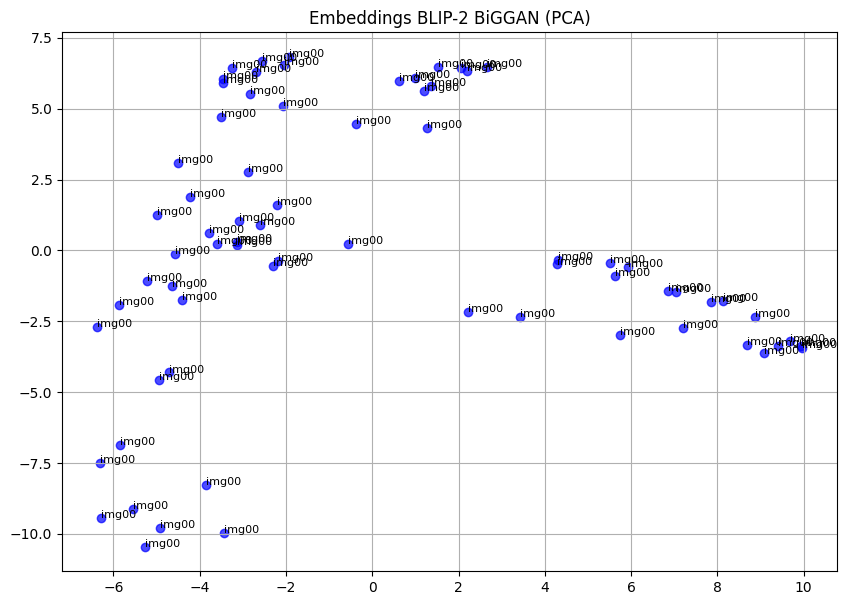

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1], c='blue', alpha=0.7)
for i, name in enumerate(file_names):
    plt.text(reduced[i, 0], reduced[i, 1], name[:5], fontsize=8)
plt.title("Embeddings BLIP-2 BiGGAN (PCA)")
plt.grid(True)
plt.show()


The embeddings themselves:

In [ ]:
import pickle

with open("blip2_embeddings_biggan.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data))


for filename, embedding in list(data.items())[:5]:
    print(filename)
    print(embedding.shape)
    print(embedding[:10])


<class 'dict'>
70
img008730.jpg
torch.Size([1408])
tensor([ 0.2696, -0.1867, -0.7289,  0.4259,  0.0735, -0.2595, -0.0778, -0.1540,
        -0.0250,  0.2993])
img008731.jpg
torch.Size([1408])
tensor([ 0.6082, -0.8612, -0.5684,  0.1602, -0.0128,  0.1498,  0.1734, -0.0356,
        -0.0062, -0.4072])
img008732.jpg
torch.Size([1408])
tensor([-0.1532, -0.2376, -0.9244, -0.2803, -0.3583, -0.3137, -0.6602,  0.1591,
         0.1583, -0.4327])
img008733.jpg
torch.Size([1408])
tensor([-0.2224, -0.4564, -0.4985,  0.2726, -0.0083, -0.8182,  0.3173,  0.1343,
         0.2036, -0.9370])
img008734.jpg
torch.Size([1408])
tensor([ 0.5056, -0.6201, -0.2208,  0.5949, -0.0093,  0.3004, -0.6526, -0.0202,
        -0.3416, -0.1974])


Third model: ViLT



ViLT: implementation for StyleGAN dataset:

In [ ]:
!pip install -q transformers kagglehub


In [ ]:
!pip install -q torch torchvision tqdm pillow


In [ ]:
import os
import torch
import pickle
from PIL import Image
from tqdm import tqdm
from transformers import ViltProcessor, ViltModel
import kagglehub

dataset_path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")
fake_path = os.path.join(dataset_path, "Final Dataset", "Fake")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ViLT
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = ViltModel.from_pretrained("dandelin/vilt-b32-mlm").to(device)
model.eval()

# first 70 images
image_files = sorted([f for f in os.listdir(fake_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:70]


embeddings = {}
for filename in tqdm(image_files):
    path = os.path.join(fake_path, filename)
    image = Image.open(path).convert("RGB")
    inputs = processor(images=image, text="", return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        emb = outputs.pooler_output.squeeze().cpu().numpy()

    embeddings[filename] = emb

with open("vilt_embeddings_stylegan.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print(len(embeddings))


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]

70


In [ ]:
import pickle
import numpy as np

with open("vilt_embeddings_stylegan.pkl", "rb") as f:
    data = pickle.load(f)

print("vilt_embeddings_stylegan.pkl:\n")
for k, v in data.items():
    print(k, ":", v.shape)


vilt_embeddings_stylegan.pkl:

001DDU0NI4.jpg : (768,)
002KDWZBHU.jpg : (768,)
002PMM0QG9.jpg : (768,)
002TJAKUYX.jpg : (768,)
003IRD4LS5.jpg : (768,)
00A0WLZE5X.jpg : (768,)
00AUP94LQS.jpg : (768,)
00B4R41FLE.jpg : (768,)
00C64W8TYZ.jpg : (768,)
00CB415UQ7.jpg : (768,)
00ELJIYESN.jpg : (768,)
00ELSET7NI.jpg : (768,)
00G7CTY1FF.jpg : (768,)
00GO3W8WCY.jpg : (768,)
00GYML2PNL.jpg : (768,)
00HZSJQ99D.jpg : (768,)
00JC8ESFO5.jpg : (768,)
00M23E4K4I.jpg : (768,)
00NDQUECJA.jpg : (768,)
00NEVKRNFZ.jpg : (768,)
00NVFY3Y64.jpg : (768,)
00NZWX01HF.jpg : (768,)
00ONA5N3VR.jpg : (768,)
00P2LUXJW3.jpg : (768,)
00PYA83V1P.jpg : (768,)
00QZ9OQ733.jpg : (768,)
00S2D5CDKQ.jpg : (768,)
00TMYXA5DF.jpg : (768,)
00TN6MYLOE.jpg : (768,)
00UBMGCRGR.jpg : (768,)
00V98STKS1.jpg : (768,)
00XN46VW5G.jpg : (768,)
00Y1BXXWM2.jpg : (768,)
01A68PBQYP.jpg : (768,)
01APKJ1WLK.jpg : (768,)
01AV0VOUAX.jpg : (768,)
01CSPULCOW.jpg : (768,)
01H47SC7ON.jpg : (768,)
01HUIAWIOM.jpg : (768,)
01HYNP6M67.jpg : (768,)
01I9EL2G0

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with open("vilt_embeddings_stylegan.pkl", "rb") as f:
    data = pickle.load(f)

keys = list(data.keys())
embeddings = np.array([data[k] for k in keys])


PCA:

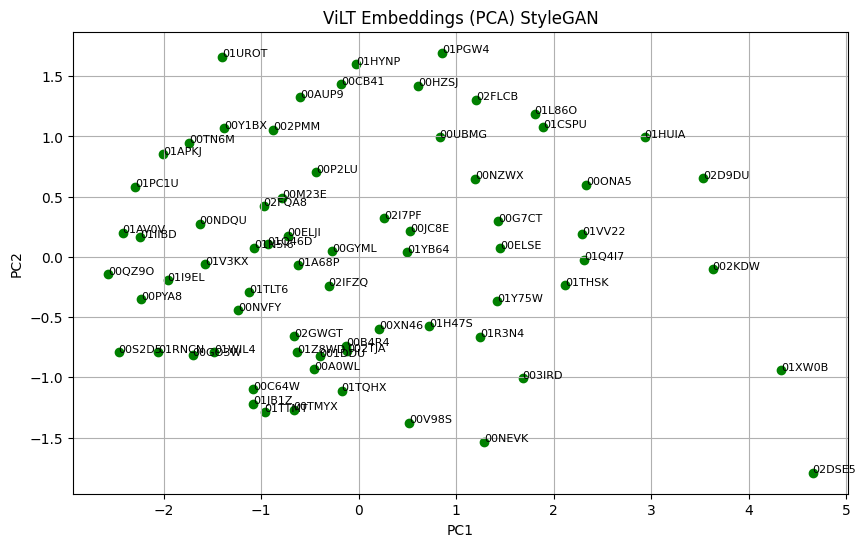

In [ ]:
# PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], color="green")

for i, key in enumerate(keys):
    plt.text(reduced[i, 0], reduced[i, 1], key[:6], fontsize=8)

plt.title("ViLT Embeddings StyleGAN (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

Теперь ViLT для DFDC:

In [ ]:
!pip install -q transformers torchvision opencv-python

In [ ]:
import os
import cv2
import torch
import pickle
from tqdm import tqdm
from PIL import Image
from transformers import ViltProcessor, ViltModel

REAL_FRAMES_PATH = "/content/DFDC/real_frames"
image_files = sorted([
    f for f in os.listdir(REAL_FRAMES_PATH)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# Only 70 images
image_paths = [os.path.join(REAL_FRAMES_PATH, f) for f in image_files[:70]]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = ViltModel.from_pretrained("dandelin/vilt-b32-mlm").to(device)
model.eval()

embeddings = {}

for img_path in tqdm(image_paths, desc="ViLT DFDC Embeddings"):
    image = Image.open(img_path).convert("RGB")

    # Placeholder text, required for ViLT
    inputs = processor(text="image", images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model(**inputs)
        embedding = output.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # CLS токен

    filename = os.path.basename(img_path)
    embeddings[filename] = embedding

with open("vilt_embeddings_dfdc.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print(len(embeddings))



ViLT DFDC Embeddings: 100%|██████████| 70/70 [01:06<00:00,  1.06it/s]

70


In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with open("vilt_embeddings_dfdc.pkl", "rb") as f:
    embeddings = pickle.load(f)

print(len(embeddings))
for i, (filename, embedding) in enumerate(embeddings.items()):
    print(filename, "->", embedding.shape)
    if i >= 5:
        break

X = list(embeddings.values())
filenames = list(embeddings.keys())


70
abarnvbtwb.mp4_frame0.jpg -> (768,)
abarnvbtwb.mp4_frame1.jpg -> (768,)
abarnvbtwb.mp4_frame2.jpg -> (768,)
abarnvbtwb.mp4_frame3.jpg -> (768,)
abarnvbtwb.mp4_frame4.jpg -> (768,)
aelfnikyqj.mp4_frame0.jpg -> (768,)


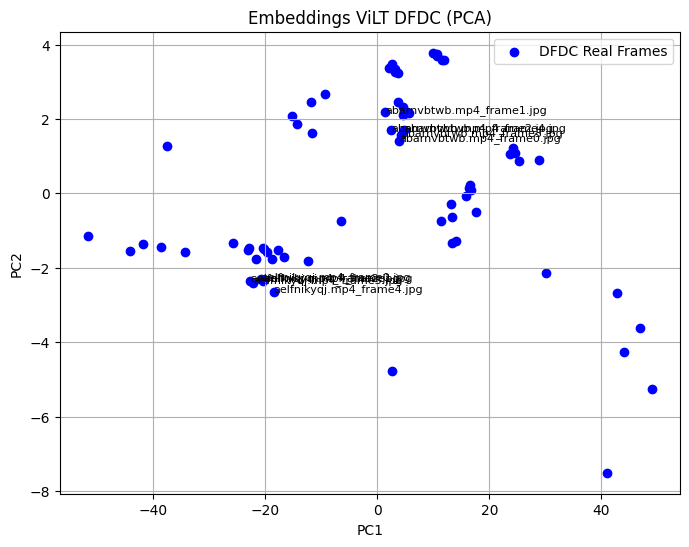

In [ ]:
# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c="blue", label="DFDC Real Frames")
for i, name in enumerate(filenames[:10]):
    plt.annotate(name, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8)

plt.title("Embeddings ViLT DFDC (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

ViLT, big_gan subset of the ArtiFact dataset:

In [ ]:
import os
import torch
import pickle
from PIL import Image
from tqdm import tqdm
from transformers import ViltProcessor, ViltModel


artifact_path = "/content/big_gan/big/biggan-data"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
model = ViltModel.from_pretrained("dandelin/vilt-b32-mlm").to(device)
model.eval()

image_paths = []
for root, dirs, files in os.walk(artifact_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

# first 70 images
image_paths = image_paths[:70]

embeddings = {}
for img_path in tqdm(image_paths, desc="ViLT BigGAN Embeddings"):
    image = Image.open(img_path).convert("RGB")

    # text -> input
    inputs = processor(text="image", images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model(**inputs)
        embedding = output.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # CLS-токен

    filename = os.path.basename(img_path)
    embeddings[filename] = embedding

with open("vilt_embeddings_biggan.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print(len(embeddings))


ViLT BigGAN Embeddings: 100%|██████████| 70/70 [00:44<00:00,  1.59it/s]

70


Content Visualization + PCA:

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with open("vilt_embeddings_biggan.pkl", "rb") as f:
    embeddings = pickle.load(f)

print(len(embeddings))
for i, (filename, emb) in enumerate(embeddings.items()):
    print(f"{filename} -> {emb.shape}")
    if i >= 5:
        break


70
img008730.jpg -> (768,)
img008731.jpg -> (768,)
img008732.jpg -> (768,)
img008733.jpg -> (768,)
img008734.jpg -> (768,)
img008735.jpg -> (768,)


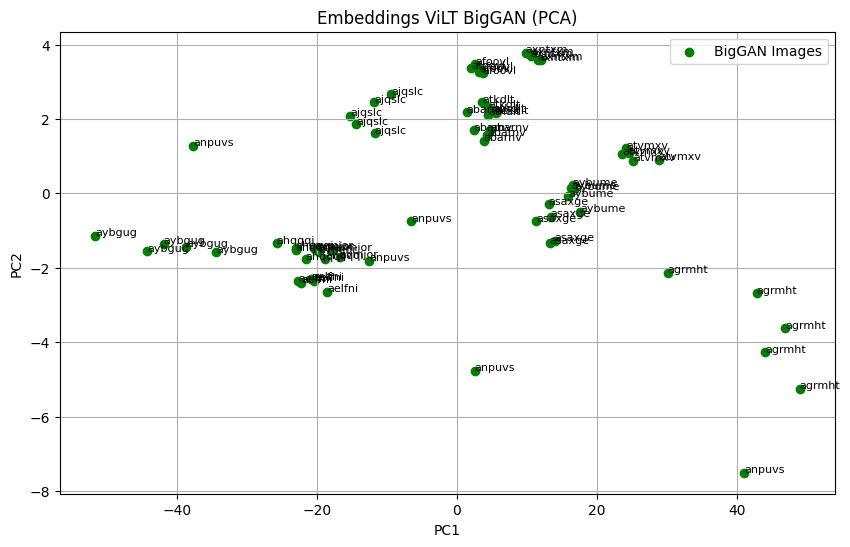

In [ ]:
# PCA
X = np.array(list(embeddings.values()))
labels = list(embeddings.keys())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color="green", label="BigGAN Images")


for i in range(len(labels)):
    plt.text(X_pca[i, 0], X_pca[i, 1], labels[i][:6], fontsize=8)

plt.title("Embeddings ViLT BigGAN (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()
plt.show()


# Analysis. Comparison of embeddings

In [ ]:
import pickle
import numpy as np

def load_embeddings(path):
    with open(path, "rb",) as f:
        return pickle.load(f)

emb_real = load_embeddings("clip_embeddings_dfdc.pkl")
emb_fake_good = load_embeddings("clip_embeddings_stylegan.pkl")
emb_fake_bad = load_embeddings("clip_embeddings_biggan.pkl")


In [ ]:
import pickle
import numpy as np

def load_embeddings(path):
    with open(path, "rb",) as f:
        return pickle.load(f)

emb_real = load_embeddings("blip2_embeddings_dfdc.pkl")
emb_fake_good = load_embeddings("blip2_embeddings_stylegan.pkl")
emb_fake_bad = load_embeddings("blip2_embeddings_biggan.pkl")

In [ ]:
import pickle
import numpy as np

def load_embeddings(path):
    with open(path, "rb",) as f:
        return pickle.load(f)

emb_real = load_embeddings("vilt_embeddings_dfdc.pkl")
emb_fake_good = load_embeddings("vilt_embeddings_stylegan.pkl")
emb_fake_bad = load_embeddings("vilt_embeddings_biggan.pkl")

Universal analysis

ViLT

In [ ]:
prefix = "vilt"

emb_real = load_embeddings(prefix + "_embeddings_dfdc.pkl")
emb_fake_good = load_embeddings(prefix + "_embeddings_stylegan.pkl")
emb_fake_bad = load_embeddings(prefix + "_embeddings_biggan.pkl")

print("Real:     ", len(emb_real))
print("StyleGAN: ", len(emb_fake_good))
print("BigGAN:   ", len(emb_fake_bad))


Real:      70
StyleGAN:  70
BigGAN:    70


CLIP

In [ ]:
prefix = "clip"

emb_real = load_embeddings(prefix + "_embeddings_dfdc.pkl")
emb_fake_good = load_embeddings(prefix + "_embeddings_stylegan.pkl")
emb_fake_bad = load_embeddings(prefix + "_embeddings_biggan.pkl")

print("Real:     ", len(emb_real))
print("StyleGAN: ", len(emb_fake_good))
print("BigGAN:   ", len(emb_fake_bad))


Real:      70
StyleGAN:  70
BigGAN:    70


BLIP-2

In [ ]:
prefix = "blip2"

emb_real = load_embeddings(prefix + "_embeddings_dfdc.pkl")
emb_fake_good = load_embeddings(prefix + "_embeddings_stylegan.pkl")
emb_fake_bad = load_embeddings(prefix + "_embeddings_biggan.pkl")

print("Real:     ", len(emb_real))
print("StyleGAN: ", len(emb_fake_good))
print("BigGAN:   ", len(emb_fake_bad))


Real:      70
StyleGAN:  70
BigGAN:    70


In [ ]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt

def load_embeddings(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def analyze_model(prefix):
    print()
    print("Model analysis")

    emb_real = load_embeddings(prefix + "_embeddings_dfdc.pkl")
    emb_fake_good = load_embeddings(prefix + "_embeddings_stylegan.pkl")
    emb_fake_bad = load_embeddings(prefix + "_embeddings_biggan.pkl")

    X_real = np.array(emb_real if isinstance(emb_real, list) else list(emb_real.values()))
    X_good = np.array(emb_fake_good if isinstance(emb_fake_good, list) else list(emb_fake_good.values()))
    X_bad = np.array(emb_fake_bad if isinstance(emb_fake_bad, list) else list(emb_fake_bad.values()))


    def stat_pairwise(a, b):
        return {
            "cosine": np.mean(cosine_distances(a, b)),
            "euclid": np.mean(euclidean_distances(a, b))
        }

    print()
    print("Interclass distances:")
    print("Real vs StyleGAN:", stat_pairwise(X_real, X_good))
    print("Real vs BigGAN  :", stat_pairwise(X_real, X_bad))
    print("StyleGAN vs BigGAN:", stat_pairwise(X_good, X_bad))

    print()
    print("Intraclass distances:")
    print("Real:     ", euclidean_distances(X_real).mean())
    print("StyleGAN: ", euclidean_distances(X_good).mean())
    print("BigGAN:   ", euclidean_distances(X_bad).mean())

    X_all = np.vstack([X_real, X_good, X_bad])
    labels_true = [0]*len(X_real) + [1]*len(X_good) + [2]*len(X_bad)

    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_all)
    labels_pred = kmeans.labels_

    ari = adjusted_rand_score(labels_true, labels_pred)
    sil = silhouette_score(X_all, labels_pred)

    print()
    print("Clustering assessment:")
    print("ARI (Adjusted Rand Index):", round(ari, 4))
    print("Silhouette Score:", round(sil, 4))

    # PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_all)
    colors = ['blue', 'green', 'red']
    classes = ['Real', 'StyleGAN', 'BigGAN']

    plt.figure(figsize=(8, 6))
    for i in range(3):
        idx = np.array(labels_true) == i
        plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], color=colors[i], label=classes[i], alpha=0.6)
    plt.title("PCA Embeddings (" + prefix.upper() + ")")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()



Model analysis

Interclass distances:
Real vs StyleGAN: {'cosine': np.float32(1.0324734), 'euclid': np.float32(28.40786)}
Real vs BigGAN  : {'cosine': np.float32(0.7902268), 'euclid': np.float32(30.977526)}
StyleGAN vs BigGAN: {'cosine': np.float32(1.0107875), 'euclid': np.float32(26.516916)}

Intraclass distances:
Real:      25.998392
StyleGAN:  2.998665
BigGAN:    28.467834

Clustering assessment:
ARI (Adjusted Rand Index): 0.2115
Silhouette Score: 0.5404


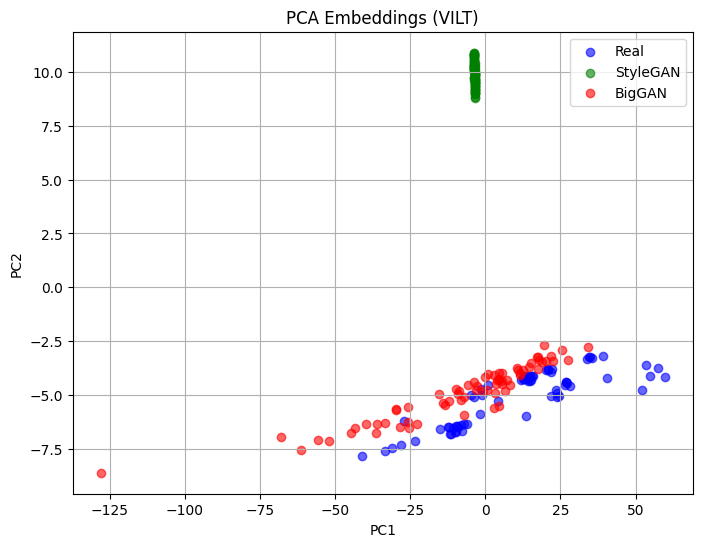

In [ ]:
analyze_model("vilt")



Model analysis

Interclass distances:
Real vs StyleGAN: {'cosine': np.float32(0.47923595), 'euclid': np.float32(10.333182)}
Real vs BigGAN  : {'cosine': np.float32(0.51545215), 'euclid': np.float32(10.927138)}
StyleGAN vs BigGAN: {'cosine': np.float32(0.5270483), 'euclid': np.float32(10.974219)}

Intraclass distances:
Real:      7.377468
StyleGAN:  8.721456
BigGAN:    9.290544

Clustering assessment:
ARI (Adjusted Rand Index): 1.0
Silhouette Score: 0.1822


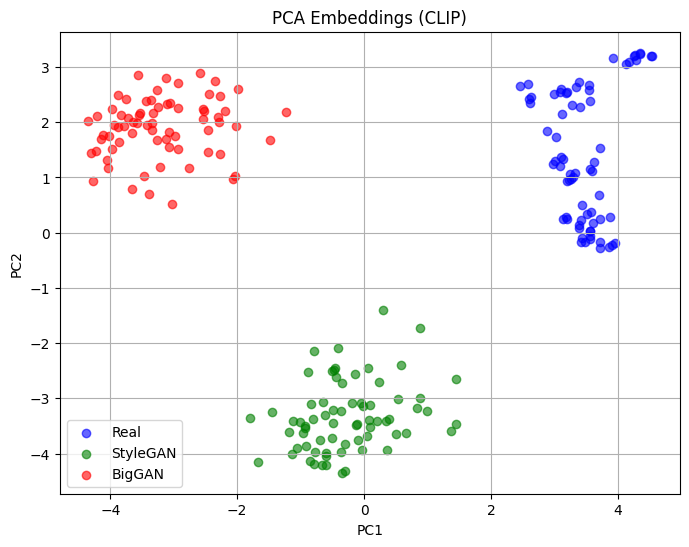

In [ ]:
analyze_model("clip")


Model analysis

Interclass distances:
Real vs StyleGAN: {'cosine': np.float32(0.61901844), 'euclid': np.float32(20.075632)}
Real vs BigGAN  : {'cosine': np.float32(0.67010033), 'euclid': np.float32(21.073368)}
StyleGAN vs BigGAN: {'cosine': np.float32(0.6872794), 'euclid': np.float32(21.230145)}

Intraclass distances:
Real:      14.160951
StyleGAN:  16.533237
BigGAN:    19.00488

Clustering assessment:
ARI (Adjusted Rand Index): 1.0
Silhouette Score: 0.1766


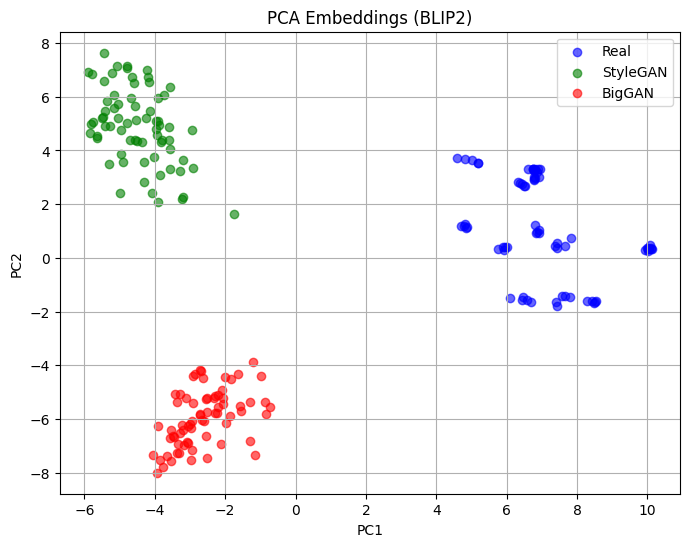

In [ ]:
analyze_model("blip2")


Calculating ARI and Silhouette Score:

In [ ]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.stats import entropy
import matplotlib.pyplot as plt

def load_embeddings(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def to_array(emb):
    return np.array(list(emb.values())) if isinstance(emb, dict) else np.array(emb)

prefixes = ["clip", "blip2", "vilt"]

for prefix in prefixes:

    emb_real = load_embeddings(f"{prefix}_embeddings_dfdc.pkl")
    emb_fake_good = load_embeddings(f"{prefix}_embeddings_stylegan.pkl")
    emb_fake_bad = load_embeddings(f"{prefix}_embeddings_biggan.pkl")

    X_real = to_array(emb_real)
    X_good = to_array(emb_fake_good)
    X_bad = to_array(emb_fake_bad)

    X_all = np.vstack([X_real, X_good, X_bad])
    labels_true = [0]*len(X_real) + [1]*len(X_good) + [2]*len(X_bad)

    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_all)
    labels_pred = kmeans.labels_

    ari = adjusted_rand_score(labels_true, labels_pred)
    sil = silhouette_score(X_all, labels_pred)

    print("ARI:", round(ari, 4))
    print("Silhouette Score:", round(sil, 4))


ARI: 1.0
Silhouette Score: 0.1822
ARI: 1.0
Silhouette Score: 0.1766
ARI: 0.2115
Silhouette Score: 0.5404


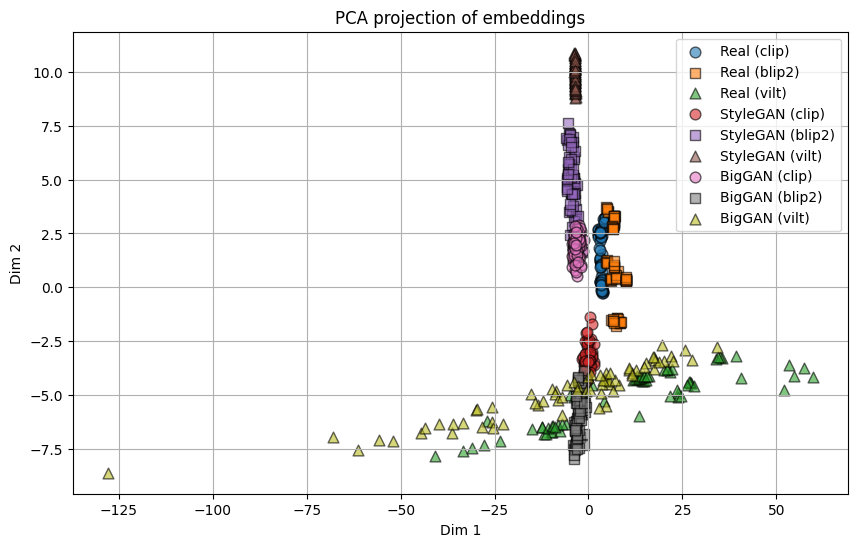

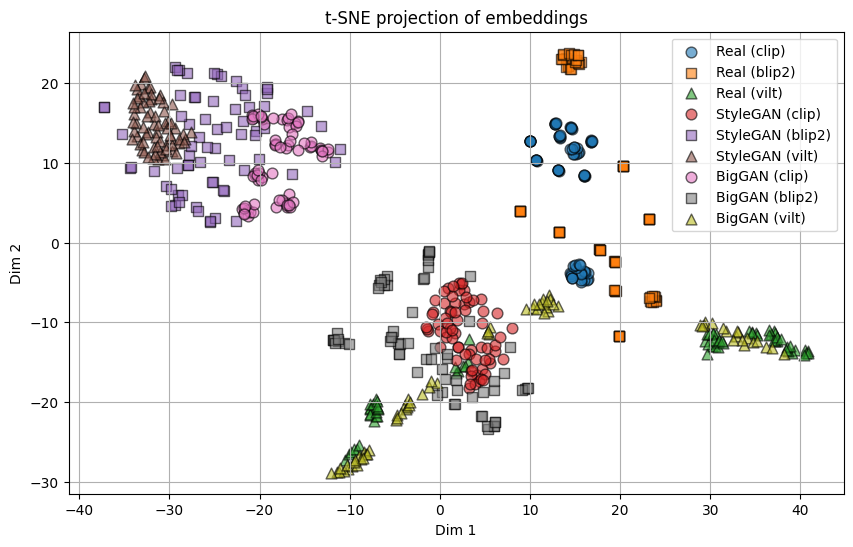

In [ ]:
import pickle
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def load_embeddings(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def to_array(emb):
    return np.array(list(emb.values())) if isinstance(emb, dict) else np.array(emb)

# Common size
COMMON_DIM = 100

models = ["clip", "blip2", "vilt"]
classes = ["Real", "StyleGAN", "BigGAN"]

X_all = []
labels_class = []
labels_model = []

for model in models:
    emb_real = load_embeddings(f"{model}_embeddings_dfdc.pkl")
    emb_good = load_embeddings(f"{model}_embeddings_stylegan.pkl")
    emb_bad  = load_embeddings(f"{model}_embeddings_biggan.pkl")

    # stack
    X_model = np.vstack([
        to_array(emb_real),
        to_array(emb_good),
        to_array(emb_bad)
    ])

    # PCA  -> common size
    pca = PCA(n_components=COMMON_DIM)
    X_model_reduced = pca.fit_transform(X_model)

    X_all.append(X_model_reduced)
    labels_class += [0]*len(emb_real) + [1]*len(emb_good) + [2]*len(emb_bad)
    labels_model += [model]*X_model_reduced.shape[0]

# Combined data
X_all = np.vstack(X_all)

class_names = ["Real", "StyleGAN", "BigGAN"]
colors = ['blue', 'green', 'red']
model_markers = {'clip': 'o', 'blip2': 's', 'vilt': '^'}

# PCA
X_pca = PCA(n_components=2).fit_transform(X_all)

# t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(X_all)

def plot_projection(X_proj, title):
    plt.figure(figsize=(10, 6))
    for cls_id, cls_name in enumerate(class_names):
        for model in models:
            mask = [(c == cls_id and m == model) for c, m in zip(labels_class, labels_model)]
            plt.scatter(
                X_proj[mask, 0], X_proj[mask, 1],
                label=f"{cls_name} ({model})",
                alpha=0.6,
                marker=model_markers[model],
                edgecolors='k',
                s=60
            )
    plt.legend()
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

plot_projection(X_pca, "PCA projection of embeddings")
plot_projection(X_tsne, "t-SNE projection of embeddings")


- PCA plot:
CLIP and BLIP-2 have dense clustering, especially:
Three clearly distinguishable clusters: Real, StyleGAN, BigGAN.
ViLT, on the other hand, weakly distinguishes between classes: clusters overlap, and some data are strongly deviated along one axis. This may indicate instability of representations (possibly due to the lack of text signal in real data and synthetic images).

- t-SNE plot:
t-SNE enhances visual differences - and here we see:
CLIP and BLIP-2 produce compact, distinct clusters for each class.
ViLT has a large spread of points and intersections, especially between Real and BigGAN, indicating less expressive embeddings.

So:
- CLIP and BLIP-2 provide good linear and nonlinear class separability — this is also confirmed by the ARI and Silhouette metrics.
- ViLT embeddings are less informative for the task of distinguishing fakes from real data, which is evident from the strong projection on one axis and the blurriness of the clusters.

ViLT showed the worst results in all metrics. This may be due to the lack of text modality or weak adaptation to the visual task. Therefore, it was not considered as a candidate for the final stage of analysis.

Shannon Enthropy for CLIP, BLIP2, ViLT

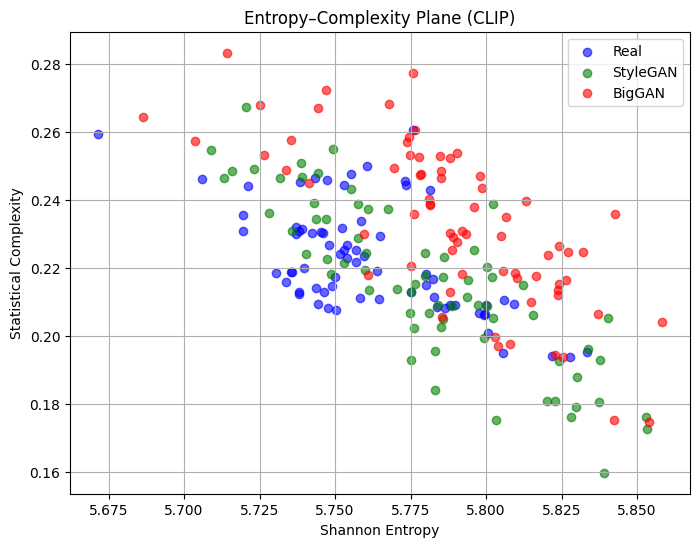

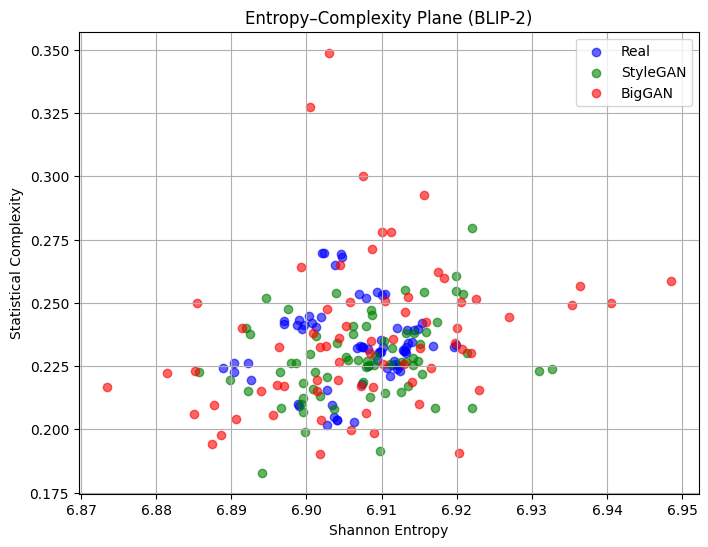

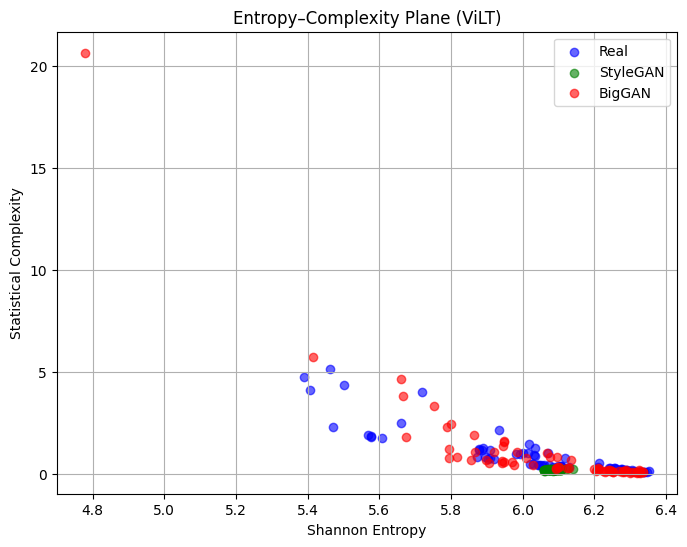

In [ ]:
import pickle
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt


def shannon_entropy(x):
    p = np.abs(x)
    p = p / np.sum(p)
    return entropy(p)

def statistical_complexity(x):
    return np.var(x)

def plot_entropy_complexity(emb_real, emb_good, emb_bad, model_name, is_dict):
    if is_dict:
        X_real = np.array(list(emb_real.values()))
        X_good = np.array(list(emb_good.values()))
        X_bad = np.array(list(emb_bad.values()))
    else:
        X_real = np.array(emb_real)
        X_good = np.array(emb_good)
        X_bad = np.array(emb_bad)

    X_all = np.vstack([X_real, X_good, X_bad])
    labels_true = [0] * len(X_real) + [1] * len(X_good) + [2] * len(X_bad)

    entropies = np.array([shannon_entropy(vec) for vec in X_all])
    complexities = np.array([statistical_complexity(vec) for vec in X_all])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    labels = ['Real', 'StyleGAN', 'BigGAN']

    for i, label in enumerate(labels):
        idx = np.array(labels_true) == i
        plt.scatter(entropies[idx], complexities[idx], alpha=0.6, label=label, color=colors[i])

    plt.xlabel("Shannon Entropy")
    plt.ylabel("Statistical Complexity")
    plt.title(f"Entropy–Complexity Plane ({model_name})")
    plt.grid(True)
    plt.legend()
    plt.show()


# CLIP
with open("clip_embeddings_dfdc.pkl", "rb") as f:
    clip_real = pickle.load(f)
with open("clip_embeddings_stylegan.pkl", "rb") as f:
    clip_stylegan = pickle.load(f)
with open("clip_embeddings_biggan.pkl", "rb") as f:
    clip_biggan = pickle.load(f)

# BLIP-2
with open("blip2_embeddings_dfdc.pkl", "rb") as f:
    blip_real = pickle.load(f)
with open("blip2_embeddings_stylegan.pkl", "rb") as f:
    blip_stylegan = pickle.load(f)
with open("blip2_embeddings_biggan.pkl", "rb") as f:
    blip_biggan = pickle.load(f)

# ViLT
with open("vilt_embeddings_dfdc.pkl", "rb") as f:
    vilt_real = pickle.load(f)
with open("vilt_embeddings_stylegan.pkl", "rb") as f:
    vilt_stylegan = pickle.load(f)
with open("vilt_embeddings_biggan.pkl", "rb") as f:
    vilt_biggan = pickle.load(f)


plot_entropy_complexity(clip_real, clip_stylegan, clip_biggan, "CLIP", is_dict=False)
plot_entropy_complexity(blip_real, blip_stylegan, blip_biggan, "BLIP-2", is_dict=True)
plot_entropy_complexity(vilt_real, vilt_stylegan, vilt_biggan, "ViLT", is_dict=True)



KL, mean interclass distance, FMI:

In [ ]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import fowlkes_mallows_score
from scipy.stats import entropy
from sklearn.cluster import KMeans

def load_embeddings(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# Mean interclass distance
def mean_interclass_distance(a, b):
    return np.mean(euclidean_distances(a, b))

# KL-divergence
def kl_divergence_histogram(a, b, bins=50):
    hist_a, _ = np.histogram(a, bins=bins, density=True)
    hist_b, _ = np.histogram(b, bins=bins, density=True)
    hist_a += 1e-10
    hist_b += 1e-10
    return entropy(hist_a, hist_b)

prefixes = ["clip", "blip2", "vilt"]

for prefix in prefixes:
    emb_real = load_embeddings(f"{prefix}_embeddings_dfdc.pkl")
    emb_fake_good = load_embeddings(f"{prefix}_embeddings_stylegan.pkl")
    emb_fake_bad = load_embeddings(f"{prefix}_embeddings_biggan.pkl")

    # dict → list
    X_real = np.array(list(emb_real.values())) if isinstance(emb_real, dict) else np.array(emb_real)
    X_good = np.array(list(emb_fake_good.values())) if isinstance(emb_fake_good, dict) else np.array(emb_fake_good)
    X_bad  = np.array(list(emb_fake_bad.values())) if isinstance(emb_fake_bad, dict) else np.array(emb_fake_bad)

    X_all = np.vstack([X_real, X_good, X_bad])
    labels_true = [0]*len(X_real) + [1]*len(X_good) + [2]*len(X_bad)

    # Interclass distance
    print("Mean interclass distance:")
    print("Real vs StyleGAN:", round(mean_interclass_distance(X_real, X_good), 4))
    print("Real vs BigGAN  :", round(mean_interclass_distance(X_real, X_bad), 4))
    print("StyleGAN vs BigGAN:", round(mean_interclass_distance(X_good, X_bad), 4))

    # KL-divergence
    print("KL-divergence:")
    print("Real vs StyleGAN:", round(kl_divergence_histogram(X_real, X_good), 4))
    print("Real vs BigGAN  :", round(kl_divergence_histogram(X_real, X_bad), 4))
    print("StyleGAN vs BigGAN:", round(kl_divergence_histogram(X_good, X_bad), 4))

    # FMI
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_all)
    labels_pred = kmeans.labels_
    fmi = fowlkes_mallows_score(labels_true, labels_pred)
    print("Fowlkes–Mallows Index (FMI):", round(fmi, 4))

Mean interclass distance:
Real vs StyleGAN: 10.3332
Real vs BigGAN  : 10.9271
StyleGAN vs BigGAN: 10.9742
KL-divergence:
Real vs StyleGAN: 1.6233
Real vs BigGAN  : 0.6485
StyleGAN vs BigGAN: 0.4604
Fowlkes–Mallows Index (FMI): 1.0
Mean interclass distance:
Real vs StyleGAN: 20.0756
Real vs BigGAN  : 21.0734
StyleGAN vs BigGAN: 21.2301
KL-divergence:
Real vs StyleGAN: 0.0396
Real vs BigGAN  : 0.1647
StyleGAN vs BigGAN: 0.0444
Fowlkes–Mallows Index (FMI): 1.0
Mean interclass distance:
Real vs StyleGAN: 28.4079
Real vs BigGAN  : 30.9775
StyleGAN vs BigGAN: 26.5169
KL-divergence:
Real vs StyleGAN: 4.7425
Real vs BigGAN  : 19.1016
StyleGAN vs BigGAN: 11.0274
Fowlkes–Mallows Index (FMI): 0.5176


KL-divergence: High divergence indicates that the classes are statistically distinguishable.
CLIP: Values ​​in the range of 0.46–1.62, reasonable — classes are well distinguishable.
BLIP2: Values ​​0.04–0.16, which is very low — BLIP2 captures the structure of the data better, the distributions are tightly localized.
ViLT: Values ​​are high (4.7–21.2) — very unstable behavior, especially KL(Real vs StyleGAN) = 4.74 and KL(Real vs BigGAN) = 19.1, indicating that the model has difficulty separating classes based on the distribution structure.

Fowlkes–Mallows Index (FMI): Clustering metric (0–1): the closer to 1, the better the correspondence of clusters to the true labels.
CLIP: FMI = 1.0 — perfect match with real labels, which confirms the excellent quality of the embedding space.
BLIP2: FMI = 1.0 — similarly, brilliant separation of classes.
ViLT: FMI = 0.5176 — much worse, the model confuses classes or their embeddings partially overlap.

CLIP and BLIP2: models that separate synthetic and real data well and produce a stable embedding space.
ViLT produces unstable or mixed embeddings, probably not suitable for final analysis without additional refinement.

Генерация подписи (Image Captioning):

In [ ]:
import os
import kagglehub


path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")


fake_path = os.path.join(path, 'Final Dataset', 'Fake')


print(os.listdir(fake_path)[:5])


['fake_639_aug_1.jpg', '1JD6S89G4D.jpg', '1KCN62R2WA.jpg', '1FKIB1PX33.jpg', '0AMO1SB5CD.jpg']


In [ ]:
import os
import torch
import pickle
from PIL import Image
from tqdm import tqdm
import kagglehub
from transformers import Blip2Processor, Blip2ForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
model.eval()

path = kagglehub.dataset_download("kshitizbhargava/deepfake-face-images")
dataset_path = os.path.join(path, 'Final Dataset', 'Fake')
dataset_name = "stylegan"
num_images = 70


image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
image_paths = image_paths[:num_images]

# captions generation
captions = {}
for img_path in tqdm(image_paths, desc="Captioning " + dataset_name):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=30)
        caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    filename = os.path.basename(img_path)
    captions[filename] = caption

with open("blip2_captions_" + dataset_name + ".pkl", "wb") as f:
    pickle.dump(captions, f)

print(dataset_name + ": " + str(len(captions)) + " captions saved.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Captioning stylegan: 100%|██████████| 70/70 [00:56<00:00,  1.24it/s]

stylegan: 70 captions saved.


In [ ]:
import pickle

with open("blip2_captions_dfdc.pkl", "rb") as f:
    captions = pickle.load(f)

for i, (filename, caption) in enumerate(captions.items()):
    print(filename, "→", caption)
    if i == 4:
        break

abarnvbtwb.mp4_frame0.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame1.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame2.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame3.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame4.jpg → a woman standing in front of a green door



In [ ]:
import pickle

with open("blip2_captions_biggan.pkl", "rb") as f:
    captions = pickle.load(f)

for i, (filename, caption) in enumerate(captions.items()):
    print(filename, "→", caption)
    if i == 4:
        break

img005400.jpg → a display of dolls in a store window

img005401.jpg → a bottle of lotion and a tube of cream

img005402.jpg → a blurry image of a bar with drinks on it

img005403.jpg → a man in a red shirt and black hat is standing next to a dog

img005404.jpg → a bottle of clear liquid sitting on a table



In [ ]:
import pickle

with open("blip2_captions_stylegan.pkl", "rb") as f:
    captions = pickle.load(f)

for i, (filename, caption) in enumerate(captions.items()):
    print(filename, "→", caption)
    if i == 4:
        break



001DDU0NI4.jpg → a woman in a red hat and a red coat

002KDWZBHU.jpg → a woman with blonde hair sitting in front of a red chair

002PMM0QG9.jpg → a man with glasses and a white shirt smiling

002TJAKUYX.jpg → a young woman smiles while standing in front of a crowd

003IRD4LS5.jpg → a young boy is smiling for the camera



In [ ]:
import os
image_folder = "/kaggle/input/deepfake-face-images/Final Dataset/Fake"
print(os.listdir(image_folder))


['fake_639_aug_1.jpg', '1JD6S89G4D.jpg', '1KCN62R2WA.jpg', '1FKIB1PX33.jpg', '0AMO1SB5CD.jpg', 'fake_46_aug_3.jpg', 'fake_373_aug_3.jpg', 'fake_510_aug_2.jpg', '0ICRTX548O.jpg', 'fake_61_aug_2.jpg', 'fake_649_aug_2.jpg', 'fake_436_aug_2.jpg', 'fake_211_aug_0.jpg', 'fake_252_aug_4.jpg', '02ZD3DCZUO.jpg', 'fake_626_aug_3.jpg', 'fake_557_aug_3.jpg', '0UNOKCNG2Y.jpg', '2ZFEBBYAFR.jpg', 'fake_425_aug_1.jpg', 'fake_19_aug_2.jpg', 'fake_621_aug_2.jpg', 'fake_61_aug_0.jpg', 'fake_588_aug_4.jpg', '00NEVKRNFZ.jpg', '2VR6LZC5B7.jpg', '0NSMTO6736.jpg', '0SREAAQWBO.jpg', '1L7UWJS6Q2.jpg', 'fake_575_aug_4.jpg', '2YU3EVAHO9.jpg', '2ATQBZS3B6.jpg', '0PTA5BDPUN.jpg', 'fake_319_aug_1.jpg', 'fake_373_aug_4.jpg', 'fake_328_aug_4.jpg', '3H7ZG8KAEF.jpg', '0O9K8UQCDS.jpg', 'fake_693_aug_4.jpg', '2FAIVXLT2K.jpg', '0R629CONWM.jpg', 'fake_110_aug_1.jpg', 'fake_319_aug_2.jpg', 'fake_35_aug_3.jpg', '2U1A7VR4KV.jpg', '2RM31GSYV6.jpg', '1JP9OR02BM.jpg', 'fake_305_aug_4.jpg', 'fake_581_aug_3.jpg', 'fake_556_aug_4.jp

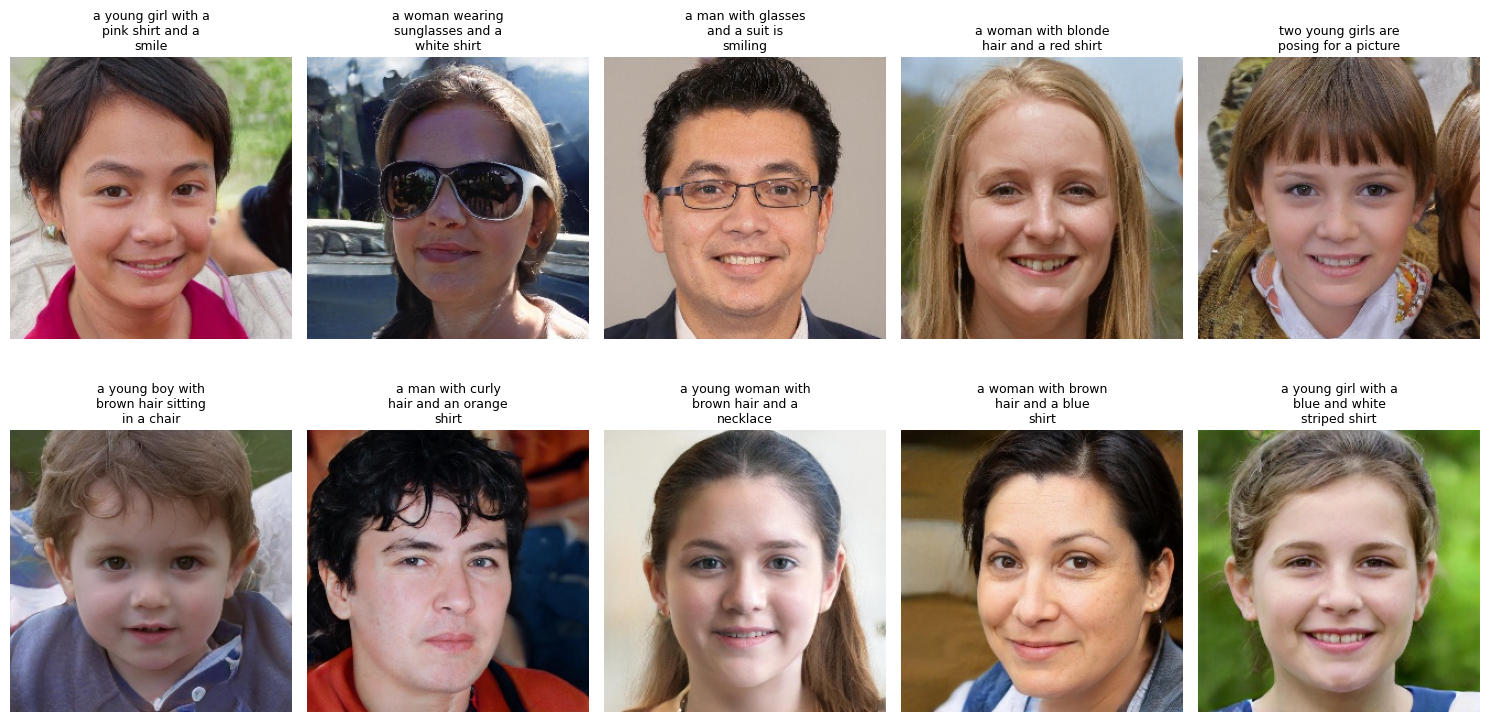

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import textwrap

image_folder = "/kaggle/input/deepfake-face-images/Final Dataset/Fake"

samples = [(filename, captions[filename]) for filename in matching_files[:10]]

num_images = len(samples)
cols = min(num_images, 5)
rows = (num_images // cols) + int(num_images % cols != 0)

plt.figure(figsize=(3 * cols, 4 * rows))


for i, (filename, caption) in enumerate(samples):
    image_path = os.path.join(image_folder, filename)
    img = Image.open(image_path)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

    wrapped_caption = "\n".join(textwrap.wrap(caption, width=20))
    plt.title(wrapped_caption, fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import pickle
from PIL import Image
from tqdm import tqdm
from transformers import Blip2Processor, Blip2ForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
model.eval()

dataset_name = "biggan"
dataset_path = "/content/big_gan/big/biggan-data"
NUM_IMAGES = 70

image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
image_paths = image_paths[:NUM_IMAGES]

captions = {}
for img_path in tqdm(image_paths, desc="Captioning " + dataset_name):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=30)
        caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    filename = os.path.basename(img_path)
    captions[filename] = caption

with open("blip2_captions_" + dataset_name + ".pkl", "wb") as f:
    pickle.dump(captions, f)

print(dataset_name + ": " + str(len(captions)) + " captions saved.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Captioning biggan: 100%|██████████| 70/70 [00:55<00:00,  1.27it/s]

biggan: 70 captions saved.


In [ ]:
import pickle

with open("blip2_captions_biggan.pkl", "rb") as f:
    captions = pickle.load(f)

for i, (filename, caption) in enumerate(captions.items()):
    print(filename, "→", caption)
    if i == 4:
        break


img005400.jpg → a display of dolls in a store window

img005401.jpg → a bottle of lotion and a tube of cream

img005402.jpg → a blurry image of a bar with drinks on it

img005403.jpg → a man in a red shirt and black hat is standing next to a dog

img005404.jpg → a bottle of clear liquid sitting on a table



In [ ]:
import os
import torch
import pickle
from PIL import Image
from tqdm import tqdm
from transformers import Blip2Processor, Blip2ForConditionalGeneration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)
model.eval()


dfdc_path = REAL_FRAMES_PATH
NUM_IMAGES = 70


image_paths = []
for root, _, files in os.walk(dfdc_path):
    for file in sorted(files):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
image_paths = image_paths[:NUM_IMAGES]

# captions generation
captions = {}
for img_path in tqdm(image_paths, desc="Captioning dfdc"):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=30)
        caption = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    filename = os.path.basename(img_path)
    captions[filename] = caption

with open("blip2_captions_dfdc.pkl", "wb") as f:
    pickle.dump(captions, f)

print("dfdc:", len(captions), "captions saved.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Captioning dfdc: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s]

dfdc: 70 captions saved.


In [ ]:
import pickle

with open("blip2_captions_dfdc.pkl", "rb") as f:
    captions = pickle.load(f)

for i, (filename, caption) in enumerate(captions.items()):
    print(filename, "→", caption)
    if i == 4:
        break


abarnvbtwb.mp4_frame0.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame1.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame2.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame3.jpg → a woman standing in front of a green door

abarnvbtwb.mp4_frame4.jpg → a woman standing in front of a green door



t-SNE

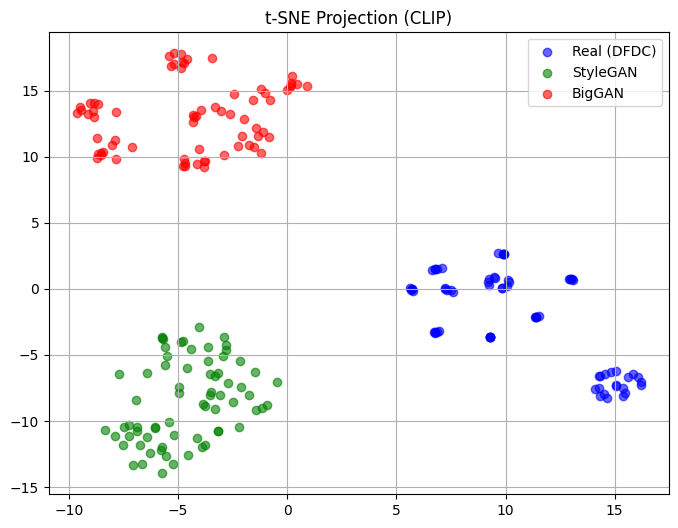

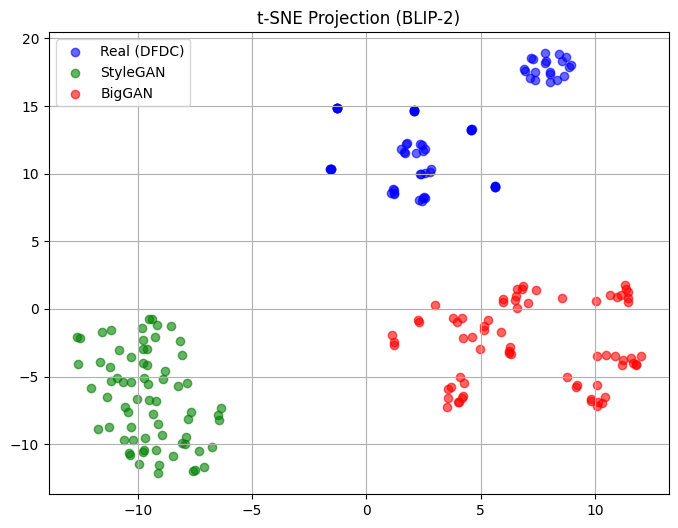

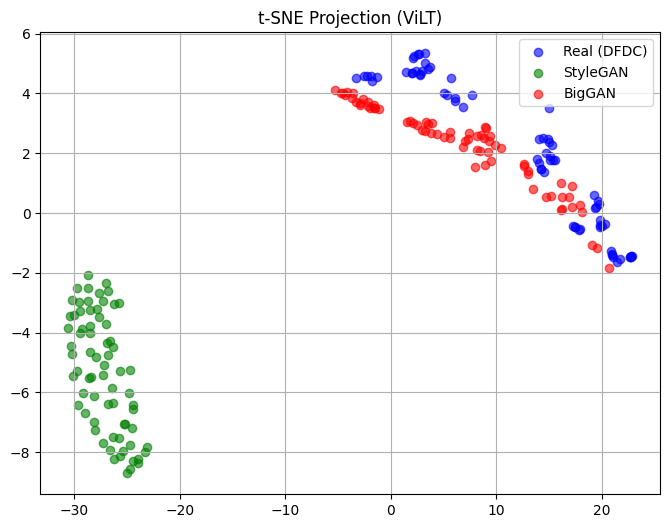

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def load_embeddings(path, is_dict):
    with open(path, "rb") as f:
        data = pickle.load(f)
        return np.array(list(data.values())) if is_dict else np.array(data)

def plot_tsne(emb_real, emb_fake_good, emb_fake_bad, model_name):
    X_all = np.vstack([emb_real, emb_fake_good, emb_fake_bad])
    y_all = [0] * len(emb_real) + [1] * len(emb_fake_good) + [2] * len(emb_fake_bad)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X_all)

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    labels = ['Real (DFDC)', 'StyleGAN', 'BigGAN']

    for i, label in enumerate(labels):
        idx = np.array(y_all) == i
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, alpha=0.6, color=colors[i])

    plt.title(f"t-SNE Projection ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()


# CLIP
clip_real = load_embeddings("clip_embeddings_dfdc.pkl", is_dict=False)
clip_stylegan = load_embeddings("clip_embeddings_stylegan.pkl", is_dict=False)
clip_biggan = load_embeddings("clip_embeddings_biggan.pkl", is_dict=False)
plot_tsne(clip_real, clip_stylegan, clip_biggan, "CLIP")

# BLIP-2
blip_real = load_embeddings("blip2_embeddings_dfdc.pkl", is_dict=True)
blip_stylegan = load_embeddings("blip2_embeddings_stylegan.pkl", is_dict=True)
blip_biggan = load_embeddings("blip2_embeddings_biggan.pkl", is_dict=True)
plot_tsne(blip_real, blip_stylegan, blip_biggan, "BLIP-2")

# ViLT
vilt_real = load_embeddings("vilt_embeddings_dfdc.pkl", is_dict=True)
vilt_stylegan = load_embeddings("vilt_embeddings_stylegan.pkl", is_dict=True)
vilt_biggan = load_embeddings("vilt_embeddings_biggan.pkl", is_dict=True)
plot_tsne(vilt_real, vilt_stylegan, vilt_biggan, "ViLT")


PCA (for all)

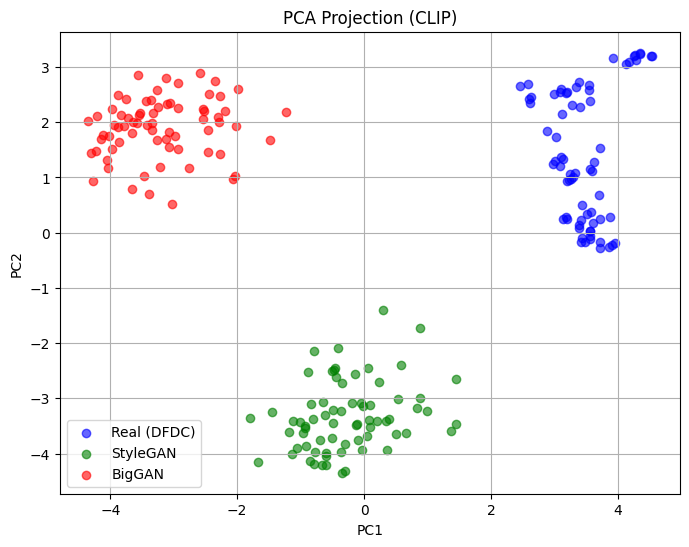

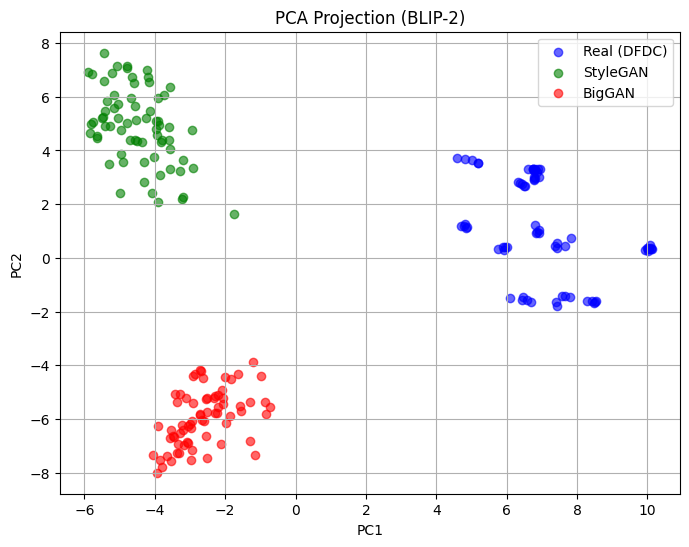

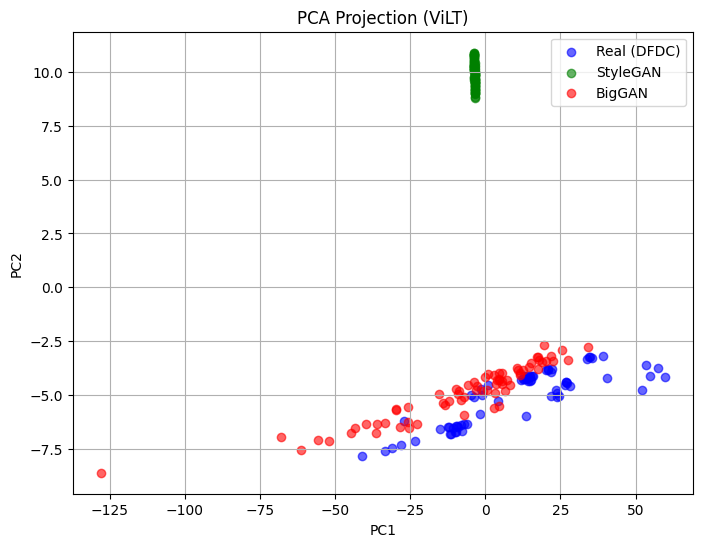

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_embeddings(path, is_dict):
    with open(path, "rb") as f:
        data = pickle.load(f)
        return np.array(list(data.values())) if is_dict else np.array(data)

def plot_pca(emb_real, emb_fake_good, emb_fake_bad, model_name):
    X_all = np.vstack([emb_real, emb_fake_good, emb_fake_bad])
    y_all = [0] * len(emb_real) + [1] * len(emb_fake_good) + [2] * len(emb_fake_bad)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_all)

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    labels = ['Real (DFDC)', 'StyleGAN', 'BigGAN']

    for i, label in enumerate(labels):
        idx = np.array(y_all) == i
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6, color=colors[i])

    plt.title(f"PCA Projection ({model_name})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()


# CLIP (list)
clip_real = load_embeddings("clip_embeddings_dfdc.pkl", is_dict=False)
clip_stylegan = load_embeddings("clip_embeddings_stylegan.pkl", is_dict=False)
clip_biggan = load_embeddings("clip_embeddings_biggan.pkl", is_dict=False)
plot_pca(clip_real, clip_stylegan, clip_biggan, "CLIP")

# BLIP-2
blip_real = load_embeddings("blip2_embeddings_dfdc.pkl", is_dict=True)
blip_stylegan = load_embeddings("blip2_embeddings_stylegan.pkl", is_dict=True)
blip_biggan = load_embeddings("blip2_embeddings_biggan.pkl", is_dict=True)
plot_pca(blip_real, blip_stylegan, blip_biggan, "BLIP-2")

# ViLT
vilt_real = load_embeddings("vilt_embeddings_dfdc.pkl", is_dict=True)
vilt_stylegan = load_embeddings("vilt_embeddings_stylegan.pkl", is_dict=True)
vilt_biggan = load_embeddings("vilt_embeddings_biggan.pkl", is_dict=True)
plot_pca(vilt_real, vilt_stylegan, vilt_biggan, "ViLT")
